# Policy embeddings / k-means for POMDP graph navigation

### IMPORTS

In [1]:
import random
import os
import sys
import pathlib
import copy
import time

import numpy as np
import pandas as pd
import itertools
import networkx as nx
from networkx.generators.random_graphs import erdos_renyi_graph

import matplotlib.pyplot as plt
from random import sample, randint
from tqdm import tqdm
from multiprocessing import Pool

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min


path = pathlib.Path(os.getcwd())
module_path = str(path.parent) + '/'
sys.path.append(module_path)

try:
    import pymdp.core.control as control
    from pymdp.core import utils
except:
    import pymdp.control as control
    from pymdp import utils
    

from scipy.special import softmax, kl_div
from scipy.stats import entropy

import sklearn
from sklearn.decomposition import PCA

## 1. BUILD GRAPH

In [2]:
def generate_graph(n=5, p=0.5, weight_options=None, idleness_penalty=100):
    G = erdos_renyi_graph(n, p, directed=True)

    weight_options = weight_options or [5,5,10,20]
    node_color="gray"
    pos = [0,1,2,3,4,5,6]

    for i in G.edges():
        G[i[0]][i[1]]['weight'] = random.choice(weight_options)
        edge_weight = G.get_edge_data(i[0], i[1])
        G.add_edge(i[1],i[0], weight=edge_weight["weight"]) 

    for e in G.nodes():
        G.add_edge(e,e,weight=idleness_penalty)
        G.nodes[e]["pos"]=[e, random.choice(pos) ]

    nx.set_node_attributes(G, node_color, "node_color")

    G.removed_edges = [] # Special property for keeping track of removed tracks
    G.idleness_penalty = idleness_penalty
    G.distances = {k: v for (k, v) in list(nx.all_pairs_dijkstra_path_length(G))}
    
    return G


### Get attributes and plot graph

In [3]:
def plot_graph(graph, path=None, labels_on=True):
    if path:
        start = path[0]
        end = path[-1]        
        path_edges = []
        
        for idx, node in enumerate(path[1:]):
            if idx < len(path) - 1:
                path_edges.append((path[idx], path[idx+1]))
            nx.set_node_attributes(graph, {node: "yellow"}, name="node_color")

        nx.set_node_attributes(graph, {start: "green"}, name="node_color")
        nx.set_node_attributes(graph, {end: "#8757b0"}, name="node_color")
    
    all_edges = list(graph.edges())
    node_pos=nx.get_node_attributes(graph,'pos')
    graph_weights = [graph[u][v]['weight'] for u,v in all_edges]
    node_colors= []
    for node in list(graph.nodes(data=True)):
        node_colors.append(node[1]["node_color"])

    nx.draw(graph, with_labels=True, node_size = 300, pos=node_pos, node_color=node_colors, width=1)
    nx.draw_networkx_edges(graph, node_pos)
    if path:
        nx.draw_networkx_edges(graph, pos=node_pos, edgelist=path_edges, width=4, edge_color='r')

    edge_labels = {e: w for e, w in zip(all_edges, graph_weights)}
    if labels_on:
        nx.draw_networkx_edge_labels(graph, node_pos, edge_labels=edge_labels)

    plt.show()


## 2. BUILD GENERATIVE MODEL

### Set up states, observations, and actions

In [4]:
def observations_from_graph(graph):
    return {
        "pair_plus_edge_weight": 
        list([[edge, graph.get_edge_data(edge[0], edge[1])["weight"]] for edge in list(graph.edges)])
    }
    
def get_weights(observations):
    return np.array([obs[1] for obs in observations['pair_plus_edge_weight']])
    
def state_space_from_graph(graph):
    states = {"node_pair": list(graph.edges)}
    observations = observations_from_graph(graph)
    actions = {"change_location": 
        [edge for edge in list(itertools.product(list(graph.edges),repeat=2)) 
        if edge[0][1] == edge[1][0]]
    }
    
    # Handy variables for dimensions of state space
    num_state_factors = len(states)
    num_states = [len(states[factor]) for factor in states]
    num_modalities = len(observations)
    num_observations = [len(observations[modality]) for modality in observations]
    num_actions = len(actions['change_location'])
    
    # Summarize edge weights in a variable
    weights = np.array([obs[1] for obs in observations['pair_plus_edge_weight']])
    
    return states, observations, actions, num_state_factors, num_states, num_modalities, num_observations, num_actions, weights


### Set up policies

In [5]:
def find_paths_recursive(graph,u,n):
    if n==0:
        return [[u]]
    paths = [[u]+path for neighbor in graph.neighbors(u) for path in find_paths_recursive(graph,neighbor,n-1)]
    return paths


def find_paths_all_nodes(graph, policy_len):
    paths = []
    for n in tqdm(graph.nodes()):
        paths += find_paths_recursive(graph, n, policy_len)
    return paths


def convert_to_edges(paths):
    path_edges = []
    for path in tqdm(paths):
        one_path_edges = []
        for idx,node in enumerate(path[1:]):
            one_path_edges.append((path[idx],path[idx+1]))
        path_edges.append(one_path_edges)
    
    return path_edges


def convert_to_policies(edge_sets, actions, policy_len, num_controllable_factors):
    path_policies = []
    for edge_set in tqdm(edge_sets):
        edge_actions = []
        for idx, edge_tuple in enumerate(edge_set[1:]):
            edge_actions.append(actions['change_location'].index((edge_set[idx], edge_set[idx+1])))
        path_policies.append(np.array(edge_actions).reshape(policy_len, num_controllable_factors))
    
    return path_policies


def get_policies_from_graph(graph, actions, num_controllable_factors, policy_len=None):
    """
    Get all policies on graph that are 'well-formed', i.e. only actions that begin 
    on the node that the previous action ended at are used
    """
    if not policy_len:
        policy_len = len(list(graph.nodes()))
    print("Getting paths recursively...")
    paths = find_paths_all_nodes(graph, policy_len+1)
    print("Getting edges...")
    path_edges = convert_to_edges(paths)
    print("Getting policies...")
    return np.array(convert_to_policies(path_edges, actions, policy_len, num_controllable_factors))


### Set up matrices
#### A Matrix
Structure: [observation_modality][observation_level, state_factor_1, ..., state_factor_n]

In [6]:
def A_setup(num_states, num_state_factors):
    # For now assuming just one observation modality and an identity mapping
    return np.array([
        np.eye(num_states[factor]) for factor in range(num_state_factors)
    ], dtype='object')


#### B Matrix
Structure: [state_factor][current_state, previous_state, action]

In [7]:
def B_setup(states, actions, graph, num_states, num_state_factors, num_actions):
    B = np.array([
        np.zeros((num_states[factor], num_states[factor], num_actions))
        for factor in range(num_state_factors)
    ], dtype='object')

    # Fill out values for valid moves
    for factor_idx, factor in enumerate(states):
        for prev_idx in range(num_states[factor_idx]):
            for current_idx in range(num_states[factor_idx]):
                for action_idx in range(num_actions):
                    if (
                        states['node_pair'][prev_idx], 
                        states['node_pair'][current_idx]
                    ) == actions['change_location'][action_idx]:
                        if actions['change_location'][action_idx][0] in list(graph.edges):
                            B[factor_idx,current_idx,prev_idx,action_idx] = 1.
                        else:
                            resulting_state_idx = states['node_pair'].index(
                                (states['node_pair'][prev_idx][1], 
                                 states['node_pair'][prev_idx][1])
                            )
                            B[factor_idx,resulting_state_idx,prev_idx,action_idx] = 1.
                    else:
                        if states['node_pair'][prev_idx] != actions['change_location'][action_idx][0]:
                            resulting_state_idx = states['node_pair'].index(
                                (states['node_pair'][prev_idx][1], 
                                 states['node_pair'][prev_idx][1])
                            )
                            B[factor_idx,resulting_state_idx,prev_idx,action_idx] = 1.
    return B


#### C Matrix

In [8]:
def C_setup(graph, states, num_states, desired_state_idx=None, graph_to_augment=None):

    # For now, assume just one observation modality
    C = np.array([
        np.zeros(num_states[idx]) for idx, factor in enumerate(states)
    ], dtype = 'float32')

    if desired_state_idx is not None:
        destination = desired_state_idx
    else:
        # Choose a random destination node
        destination = np.random.randint(len(list(graph.nodes)))

    # Distribute positive preferences over paths that terminate at this destination
    desired_indices = np.where(
        np.array([states['node_pair'][state][1] for state in range(num_states[0])]) 
        == destination
    )[0]
    
    print("Desired indices", desired_indices)
    if len(desired_indices) > 0:
        C[0][desired_indices] = 1./len(desired_indices)
    else:
        print("Destination unreachable. C matrix is flat")
        C[0] += 1./C[0].shape[0]
    
    if graph_to_augment:
        for idx in range(graph_to_augment.number_of_nodes()):
            if idx != desired_state_idx:
                G[idx][idx]['weight'] = 0
    
    return C, destination


#### D Matrix / initial conditions

In [9]:
def D_setup(graph, states, num_states, num_state_factors, initial_state=None):
        
    if initial_state is None:
        edges = list(graph.edges())
        initial_state_idx = np.random.choice(len(edges))
        initial_state = edges[initial_state_idx]
        print(initial_state)
    
    initial_beliefs = np.array([
        np.zeros(num_states[factor_idx])
        for factor_idx in range(num_state_factors)
    ])
    initial_beliefs[0][states['node_pair'].index(initial_state)] = 1.
    
    return initial_beliefs


## 4. POLICY SELECTION

Select random points rather than centroids

In [10]:
def select_random_points(clusters,number_of_points):
    selected_points=[]
    for cluster in clusters:
        selected_points.append(random.sample(cluster, size=number_of_points, replace=False))  
    return selected_points

def select_average_policy_kmeans(cluster_points, clusters, policies_list, Qs, A, B, C, weights, weight_coefficient, number_of_points):
    cluster_EFEs = []
    selected_points = select_random_points(clusters, number_of_points)
    for idx, cluster in enumerate(clusters):
        cluster_average = []
        
        for selected_point in selected_points[idx]:
            
            cluster_average.append(
                -evaluate_policy(policies_list[selected_point], Qs, A, B, C, weights, weight_coefficient)
            )
        cluster_EFEs.append(sum(cluster_average)/len(cluster_average))
    # print("CLUSTER EFEs", cluster_EFEs)
    chosen_cluster_idx = np.argmin(cluster_EFEs)
    print("chosen-idx", chosen_cluster_idx)
    
    return clusters[chosen_cluster_idx]


## 5. SIMULATION SETUP
Core policy selection functions adapted from pymdp tutorial notebook


#### Function to plot beliefs

Function to plot performance in time and accuracy of the simulation over trials

 - over 20 trials
    - time and accuracy of each approach 
        - embedding vs no embedding
        - BOE vs EDM
        -  MBOE vs BOE and EDM

- accuracy: 
    - minimal distance to destination, and stationarity over destination
- Time: seconds to run the program and finish the simulation 
    - time constructing embeddings
    - time to do k-means
    - time to select policy
    - time for overall simulation

In [11]:
def time_function(function, *args, **kwargs):
    start = time.time()
    function(*args, **kwargs)
    end = time.time()
    result=[end-start, end, start]
    print(result)
    return result

def plot_time_function(results, title):
    plt.figure(zorder=0)
    plt.add_axes([0,0,1,1])
    plt.plot(results, range(len(results)))
    plt.title(title)
    plt.show()

def plot_compare_time_function(results, results2, title):
    plt.figure(zorder=0)
    plt.add_axes([0,0,1,1])
    plt.plot(results, range(len(results)))
    plt.plot(results2, range(len(results2)))
    plt.title(title)
    plt.show()

# TODO

1. Make accuracy measurement function
2. Finish GraphAgent class / simulation code
3. Run experiments
4. Update paper with results
5. (Optional) finalize/clean up repo

## 6. K-means on policy embeddings

### Policy embedding: edit distance matrix

In [12]:
def expand(policy, action_data):
    return [action_data[x[0]] for x in policy]


def extract_edges(policy, action_data, return_set=True):
    result = []  
    for action in expand(policy, action_data):
        result += [action[0], action[1]]
    if return_set:
        return set(result)

    return result


def extract_nodes(edges):
    result = []
    for edge in edges:
        result += [edge[0], edge[1]]
    return set(result)


def edit_distance(graph_A, graph_B, action_data):
    
    A_edges, B_edges = extract_edges(graph_A, action_data), extract_edges(graph_B, action_data)
    diff_edges = distinct_elements(A_edges, B_edges)
    
    A_nodes, B_nodes = extract_nodes(A_edges), extract_nodes(B_edges)
    diff_nodes = distinct_elements(A_nodes, B_nodes)
    
    return len(diff_edges) + len(diff_nodes)

    
def distinct_elements(set_A, set_B):
    return set_A.union(set_B) - set_A.intersection(set_B)


def edm_parallel(policies, num_policies, action_data):
    row = np.zeros(num_policies, dtype='int')
    for j in range(num_policies):
        row[j] = edit_distance(policies[i], policies[j], action_data)

        
from functools import partial

def edit_distance_matrix_parallel(policies, action_data):
    num_policies = len(policies)
    pool = Pool()
    
    edm_p = partial(edm_parallel, num_policies=num_policies, action_data=action_data)
    matrix = np.array(pool.imap(edm_p, policies), dtype='int') 
    
def edit_distance_matrix(policies, action_data):
    num_policies = len(policies)
    matrix = np.zeros((num_policies, num_policies), dtype='int')
    
    for i in tqdm(range(num_policies)):
        for j in range(num_policies):
            matrix[i,j] = edit_distance(policies[i], policies[j], action_data)
    return matrix
            

def starts_with(policy, location, action_data):
    return expand(policy, action_data)[0][0] == location


def print_policies(policy_list, action_data):
    for x in policy_list:
        print(expand(x, action_data))

### Policy embedding: Bag-of-policies

In [13]:
def bag_of_edges(graph, policies, action_data):
    bag = []
    for policy in tqdm(policies):
        bag.append(np.array([list(extract_edges(policy, action_data)).count(edge) for edge in graph.edges()]))
    
    return bag

def bag_of_edges_augmented(graph, policies, action_data):
    bag = []
    for policy in tqdm(policies):
        edges = list(graph.edges())
        policy_edges = extract_edges(policy, action_data, return_set=False)
        first_edge = edges.index(policy_edges[0])
        last_edge = edges.index(policy_edges[1])
        bag.append(np.array([list(extract_edges(policy, action_data)).count(edge) for edge in edges] + [first_edge, last_edge]))
    
    return bag

## K-means clustering on embedding space

In [14]:
def get_kmeans(embedding, num_clusters=12, init_strategy=None):    
    return KMeans(n_clusters=num_clusters, random_state=0).fit(np.array(embedding))


def get_local_policies(policies, current_location):
    return [x for x in policies if starts_with(x, current_location)]


def get_local_embedding(embedding, current_location, policies):
    embedding_copy = copy.deepcopy(embedding)
    embedding_copy = [x for idx, x in enumerate(embedding_copy) if starts_with(policies[idx], current_location)]

    return embedding_copy


def get_kmeans_local(embedding, current_location, policies, num_clusters=12):

        
    embedding_copy = copy.deepcopy(embedding)
    if current_location:
        embedding_copy = [x for idx, x in tqdm(enumerate(embedding_copy)) if starts_with(policies[idx], current_location)]

    return embedding_copy, KMeans(n_clusters=num_clusters, random_state=0).fit(np.array(embedding_copy))

## 7. RUN SIMULATION

## Agent and Simulation classes

In [37]:
EMBEDDINGS = ["EDM", "BOE", "aBOE"]


class GraphAgent():
    def __init__(
        self, 
        graph, 
        embedding_style="None", 
        embeddings=EMBEDDINGS, 
        use_local_policies=True, 
        local_kmeans=True, 
        k=12, 
        weight_coefficient=5
    ):
        self.graph = graph
        self.use_local_policies = use_local_policies
        self.local_kmeans = local_kmeans
        self.weight_coefficient = weight_coefficient
        self.idleness_penalty = graph.idleness_penalty
        self.k = k
        self.use_kmeans = embedding_style != "None"

        # States, observations, actions
        ( self.states,
        self.observations, 
        self.actions, 
        self.num_state_factors, 
        self.num_states, 
        self.num_modalities, 
        self.num_observations, 
        self.num_actions, 
        self.weights ) = state_space_from_graph(graph)
 
        # Generative model
        self.A = A_setup(self.num_states, self.num_state_factors)
        self.B = B_setup(self.states, self.actions, graph, self.num_states, self.num_state_factors, self.num_actions)
        self.C, self.desired_node = C_setup(graph, self.states, self.num_states)
        self.D = D_setup(graph, self.states, self.num_states, self.num_state_factors)
        
        # Policies
        self.policy_len = len(list(graph.nodes()))
        print("Deriving policies from graph...")
        self.all_policies = get_policies_from_graph(graph, self.actions, self.num_state_factors)
        self.policies = copy.deepcopy(self.all_policies)
        
        self.initialize_beliefs_and_state()
        self.initialize_logs()
        self.reset_weights()

        # Embeddings
        self.embedding_style = embedding_style
        self.embeddings = {}
        self.construction_times = {}
        
        if "EDM" in embeddings:
            print("Building edit distance matrix representation...")
            start = time.time()
            self.embeddings["EDM"] = edit_distance_matrix(self.all_policies, self.actions["change_location"])
            duration = time.time() - start
            self.construction_times["EDM"] = duration
        if "BOE" in embeddings:
            print("Building bag-of-edges representation...")
            start = time.time()
            self.embeddings["BOE"] = bag_of_edges(graph, self.all_policies, self.actions["change_location"])
            duration = time.time() - start
            self.construction_times["BOE"] = duration
        if "aBOE" in embeddings:
            print("Building augmented bag-of-edges representation...")
            start = time.time()
            self.embeddings["aBOE"] = bag_of_edges_augmented(graph, self.all_policies, self.actions["change_location"])
            duration = time.time() - start
            self.construction_times["aBOE"] = duration
            
        if self.use_kmeans:
            self.init_kmeans()
                
    # Current state updates
    
    def set_policy_select_mode(self, embedding_style):
        modes = ["None", "EDM", "BOE", "aBOE"]
        assert embedding_style in modes, f"Policy modes are : [{' '.join(modes)}]"
        self.embedding_style = embedding_style
        self.use_kmeans = self.embedding_style != "None"
        self.init_kmeans()
    
    def init_kmeans(self):
        if self.use_kmeans:
            if self.local_kmeans:
                self.create_local_embeddings()
            else:        
                self.get_kmeans()
                self.get_agent_kmeans(self.embeddings[self.embedding_style], self.kmeans)
    
    def initialize_beliefs_and_state(self):
        self.beliefs = self.D[0]
        self.state = np.argmax(self.beliefs) # Initialize state to match belief
        self.believed_location = self.states["node_pair"][self.state]
    
    def initialize_logs(self):
        self.state_history = [self.state]
        self.node_history= [self.states["node_pair"][self.state][1]]
        self.inference_times = []
        
    def reset_weights(self):
        for n in range(len(list(self.graph))):
            self.graph.add_edge(n, n, weight=0 if n == self.desired_node else self.idleness_penalty)
        self.observations = observations_from_graph(self.graph)
        self.weights = get_weights(self.observations)
            
    def reset_state(self, embedding_style=None):
        self.reset_weights()
        self.initialize_beliefs_and_state()
        self.initialize_logs()
        self.policies = copy.deepcopy(self.all_policies)
        if embedding_style is not None:
            self.set_policy_select_mode(embedding_style)
    
    def update_believed_location(self):
        """Update belief about agent's current location"""
        self.believed_location = self.states["node_pair"][np.argmax(self.beliefs)]
        return self.believed_location

    def get_local_policies(self, location):
        return [x for x in self.all_policies if starts_with(
            x, location, self.actions["change_location"]
        )] 

    def update_local_policies(self):
        """Return policies viable from agent's current *believed* location"""
        self.policies = self.get_local_policies(self.believed_location)
        return self.policies

    def relax_penalty(self):
        """No penalty for idling on destination node"""
        self.graph.add_edge(self.desired_node, self.desired_node, weight=0)
        destination_idx = self.observations['pair_plus_edge_weight'].index(
            [(self.desired_node,self.desired_node),self.idleness_penalty])
        self.observations["pair_plus_edge_weight"][destination_idx] = [(self.desired_node, self.desired_node), 0]        
    
    
    # K-means
        
    def get_kmeans(self):
        """Get k-means for global policy space"""
        assert self.use_kmeans, "Agent not set to use k-means; no embedding!"
        start = time.time()
        self.kmeans = KMeans(n_clusters=self.k, random_state=0).fit(np.array(self.embeddings[self.embedding_style]))
        self.kmeans_time = time.time() - start
        
        return self.kmeans

    def get_agent_kmeans(self, policies, embedding, kmeans):
        """Return clusters in usable format, and closest policy to each k-means cluster center"""
        cluster_centers, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, embedding)        

        clusters = [
            [policy for idx, policy in enumerate(policies) if kmeans.labels_[idx] == cluster_idx]
            for cluster_idx in range(len(cluster_centers))
        ]
        return clusters, cluster_centers
        
    def update_kmeans(self):
        """get clusters and centers from local kmeans -- TODO: deprecate"""
        # local_embedding = self.embeddings_dict[self.believed_location]["embedding"]
        # local_kmeans = self.embeddings_dict[self.believed_location]["kmeans"]
        # self.clusters, self.cluster_centers = self.get_agent_kmeans(local_embedding, local_kmeans)
        self.clusters = self.embeddings_dict[self.believed_location]["clusters"]
        self.cluster_centers = self.embeddings_dict[self.believed_location]["cluster_centers"]    
        
    def get_kmeans_local(self, location):
        """Compute local k-keans given a location"""
        embedding_copy = copy.deepcopy(self.embeddings[self.embedding_style])
        if location:
            embedding_copy = [x for idx, x in enumerate(embedding_copy) if starts_with(
                self.policies[idx], location, self.actions["change_location"]
            )]
            
        return embedding_copy, KMeans(n_clusters=self.k, random_state=0).fit(np.array(embedding_copy))

    def create_local_embeddings(self):
        """Get local embeddings and corresponding local k-means in a dictionary"""
        self.embeddings_dict = dict()
        start = time.time()
        for edge in tqdm(list(self.graph.edges())):
            local_embedding, local_kmeans = self.get_kmeans_local(edge)
            local_policies = self.get_local_policies(edge)
            clusters, cluster_centers = self.get_agent_kmeans(local_policies, local_embedding, local_kmeans)
            self.embeddings_dict[edge] = {
                "embedding": local_embedding, 
                "kmeans": local_kmeans,
                "clusters": clusters,
                "cluster_centers": cluster_centers
            }
        self.kmeans_time = time.time() - start

        return self.embeddings_dict    

    
    # Policy inference / control

    def select_policy_cluster(self):
        """First step of hierarchical inference: choose policy cluster whose center has lowest EFE"""
        cluster_EFEs = []
        for cluster_center in self.cluster_centers:
            cluster_EFEs.append(
                -self.evaluate_policy(self.policies[cluster_center])
            )
        print("CEFES", cluster_EFEs)
        print("length", len(cluster_EFEs))
        chosen_cluster_idx = np.argmin(cluster_EFEs)
        print("chosen-idx", chosen_cluster_idx)
        
        self.policies = self.clusters[chosen_cluster_idx]
        return self.policies

    def choose_action(self, Q_pi):
        Qu = np.zeros([self.num_actions])

        for i, policy in enumerate(self.policies):
            u = int(policy[0])
            Qu[u] += Q_pi[i]        
        Qu /= np.sum(Qu)

        return np.where(np.random.multinomial(1, Qu))[0][0]
    
    def infer_action(self, choose_best_policy=False):
        neg_G = np.zeros([len(self.policies), 1])
                        
        for i, policy in enumerate(self.policies):
            neg_G[i] = self.evaluate_policy(policy)        

        Q_pi = softmax(neg_G)

        if choose_best_policy:
            return self.policies[np.argmax(Q_pi)][0], neg_G

        u = self.choose_action(Q_pi)

        print("u", u)
        return u, neg_G

    def evaluate_policy(self, policy):
        A = self.A[0]
        B = self.B[0]
        C = self.C[0]
        Qs = copy.deepcopy(self.beliefs)

        G = 0
        
        for t in range(len(policy)):
            u = int(policy[t])
            Qs = B[:,:,u].dot(Qs)
            Qo = A.dot(Qs)

            H = entropy(np.float32(A))

            divergence = entropy(np.float32(Qo) + 1e-16, np.float32(C) + 1e-16)
            uncertainty = H.dot(Qs)

            G += (divergence + uncertainty + (np.dot(self.weights, Qo)*(self.weight_coefficient)))

        return -G
        
    def act(self):
        start = time.time()

        self.update_believed_location()
        self.update_local_policies()
        
        if self.use_kmeans:
            if self.local_kmeans:
                self.update_kmeans()
            self.select_policy_cluster()
        
        a, EFE = self.infer_action()  
        
        duration = time.time() - start
        self.inference_times.append(duration)
        
        return a, EFE
        
    def update(self, desired_state_idx=None, impatience=False):
        """
        Re-build the policy space and generative model, given the agent's graph    
        """
        if desired_state_idx is None:
            desited_state_idx = self.desired_node
        
        self.A = A_setup(self.num_states, self.num_state_factors)
        self.B = B_setup(self.states, self.actions, self.graph, self.num_states, self.num_state_factors, self.num_actions)
        self.C, self.desired_node = C_setup(self.graph, self.states, self.num_states, desired_state_idx)

        if impatience:
            if self.states['node_pair'][self.state_history[-1]][1] == \
            self.states['node_pair'][self.state][0] == \
            self.states['node_pair'][self.state][1] and self.states['node_pair'][self.state_history[-1]][1] != self.desired_node:
                self.weight_coefficient = np.max(self.weight_coefficient - 1, 0)

        return self.A, self.B, self.C, self.weight_coefficient
        
    def infer_state(self, observation, action):
        self.beliefs = softmax(np.log(np.float32(self.A[0][observation,:]) + 1e-16) + np.log(np.float32(self.B[0][:,:,action].dot(self.beliefs)) + 1e-16))
        return self.beliefs


    def plot_graph(self):
        plot_graph(self.graph)

    def plot_beliefs(self, title=""):
        plt.grid(zorder=0)
        plt.bar(range(self.beliefs.shape[0]), self.beliefs, color='r', zorder=3)
        plt.xticks(range(self.beliefs.shape[0]))
        plt.title(title)
        plt.show()

                
class Simulation():
    def __init__(self, agent, T=10, verbose=True, plot_results=True):
        self.agent = agent
        self.T = T
        self.use_kmeans = agent.use_kmeans
        self.states = agent.states
        self.state = agent.state
        self.verbose = verbose
        self.plot_results = plot_results
        self.A = copy.deepcopy(self.agent.A)
        self.B = copy.deepcopy(self.agent.B)
    
    def vprint(self, *messages):
        if self.verbose:
            print(*messages)
    
    def step(self, timestep):
        self.vprint("")
        self.vprint("------------------------")
        self.vprint("Timestep ", timestep)        
        self.vprint(f"State: {self.agent.states['node_pair'][self.agent.state]}")

        a, _ = self.agent.act()
        a = int(a)

        self.vprint(f"Action: {self.agent.actions['change_location'][a]} (index {a})")

        # Perform action in the environment and update the environment
        self.agent.state = utils.sample(np.float32(self.B)[0][:, self.agent.state, a])
                
        self.vprint(f"New state: {self.agent.states['node_pair'][self.agent.state]}")
        o = utils.sample(np.float32(self.A)[0][:,self.agent.state])
        self.vprint(f"Observation: {self.agent.observations['pair_plus_edge_weight'][o]}")

        # Keep a running record of states
        self.agent.state_history.append(self.agent.state)
        location = self.agent.states["node_pair"][self.agent.state]
        self.agent.node_history.append(location[1])

        self.vprint("Graph:")
        nx.set_node_attributes(self.agent.graph, "grey", name="node_color")
        nx.set_node_attributes(self.agent.graph, {
            self.agent.states['node_pair'][self.agent.state][1]: "blue"
        }, name="node_color")
        
        if self.plot_results:
            plot_graph(self.agent.graph, self.agent.node_history)

        # for node1, node2, data in G.edges(data=True):
        #     print("edge:", (node1, node2), "weight:", data['weight'])

        # Update agent's model parameters
        #agent.update(agent.desired_node)

        # infer new hidden state
        b = self.agent.infer_state(o, a)
        self.vprint(f"Beliefs: ", b)
        self.agent.plot_beliefs("Beliefs (Qs) at time {}".format(timestep))
    
    def run(self):
        self.vprint("\nInitial state")
        self.vprint("-------------")
        self.vprint("Desired state", self.agent.desired_node)
        self.vprint("Initial beliefs", self.agent.beliefs)
        self.vprint("Embedding: ", self.agent.embedding_style)
        if self.plot_results:
            self.vprint("Graph:")
            nx.set_node_attributes(self.agent.graph, "grey", name="node_color")
            nx.set_node_attributes(G, {self.agent.states['node_pair'][agent.state][1]: "blue"}, name="node_color")
            plot_graph(self.agent.graph)

        for timestep in range(self.T):
            self.step(timestep)
        
        self.vprint("Times")
        self.vprint(self.agent.inference_times)
        self.vprint("\nAvg:", np.mean(self.agent.inference_times))


In [16]:
G.distances

NameError: name 'G' is not defined

In [ ]:



def experiment(
    embedding_styles=["None"] + EMBEDDINGS, 
    graph_size_range=[3,5], 
    k_values=[6,12,24],
    n=20, 
    save_interval=1
):
        experiment_nums = []
        inference_times = []
        optimal = []
        

        exp_num = 0
        for graph_size in range(graph_size_range[0], graph_size_range[1]+1):
            data[graph_size] = {}
            for idx in range(n):
                data[graph_size][idx]
                
        
        
        

Desired indices [ 1  8 10]
(2, 3)
Deriving policies from graph...
Getting paths recursively...


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 2373.69it/s]


Getting edges...


100%|███████████████████████████████████| 1204/1204 [00:00<00:00, 462915.21it/s]


Getting policies...


100%|███████████████████████████████████| 1204/1204 [00:00<00:00, 171120.67it/s]


Building edit distance matrix representation...


100%|██████████████████████████████████████| 1204/1204 [00:10<00:00, 116.53it/s]


Building bag-of-edges representation...


100%|████████████████████████████████████| 1204/1204 [00:00<00:00, 29081.32it/s]


Building augmented bag-of-edges representation...


100%|████████████████████████████████████| 1204/1204 [00:00<00:00, 26126.79it/s]


et {'EDM': 10.336161136627197, 'BOE': 0.042771339416503906, 'aBOE': 0.0476231575012207}


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 36.83it/s]


km 0.3273041248321533
et {'EDM': 10.336161136627197, 'BOE': 0.042771339416503906, 'aBOE': 0.0476231575012207}

Initial state
-------------
Desired state 2
Initial beliefs [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Embedding:  aBOE
Graph:


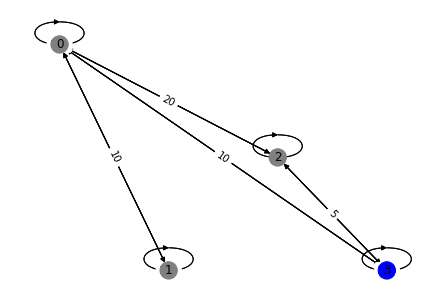


------------------------
Timestep  0
State: (2, 3)
CEFES [1697.3654479980469, 275.87994861602783, 797.3654479980469, 625.8799486160278, 250.87994861602783, 861.6226983070374, 336.62269830703735, 347.3654479980469, 650.8799486160278, 250.87994861602783, 797.3654479980469, 115.13719892501831]
length 12
chosen-idx 11
u 23
Action: ((2, 3), (3, 2)) (index 23)
New state: (3, 2)
Observation: [(3, 2), 5]
Graph:


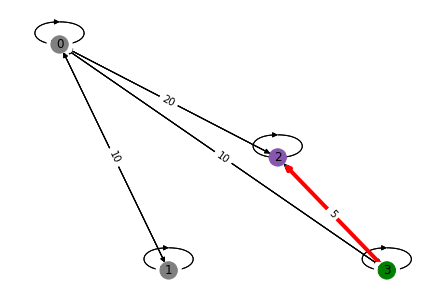

Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 1.00000e+00 9.99999e-33]


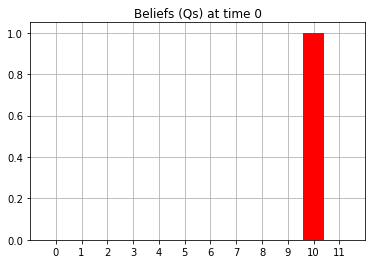


------------------------
Timestep  1
State: (3, 2)
CEFES [375.87994861602783, 325.87994861602783, 786.6226983070374, 150.87994861602783, 150.87994861602783, 236.62269830703735, 250.87994861602783, 397.3654479980469, 140.1371989250183, 475.87994861602783, 686.6226983070374, 397.3654479980469]
length 12
chosen-idx 8
u 34
Action: ((3, 2), (2, 2)) (index 34)
New state: (2, 2)
Observation: [(2, 2), 0]
Graph:


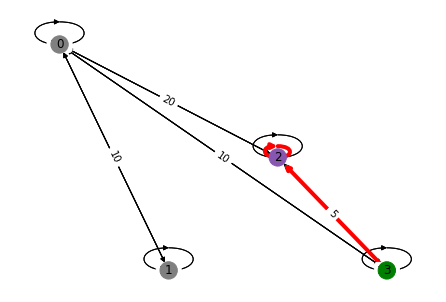

Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 1.00000e+00 9.99999e-33 9.99999e-33 9.99999e-33]


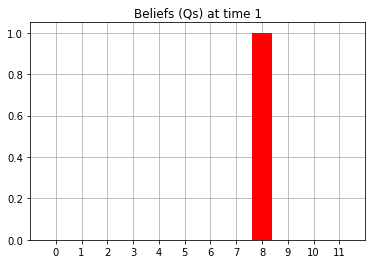


------------------------
Timestep  2
State: (2, 2)
CEFES [322.3654479980469, 397.3654479980469, 225.87994861602783, 475.87994861602783, 236.62269830703735, 225.87994861602783, 140.1371989250183, 397.3654479980469, 686.6226983070374, 386.62269830703735, 311.62269830703735, 150.87994861602783]
length 12
chosen-idx 6
u 27
Action: ((2, 2), (2, 2)) (index 27)
New state: (2, 2)
Observation: [(2, 2), 0]
Graph:


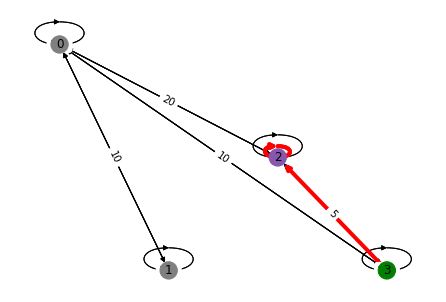

Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 1.00000e+00 9.99999e-33 9.99999e-33 9.99999e-33]


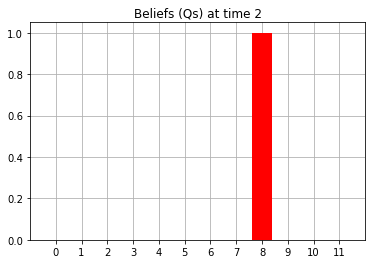


------------------------
Timestep  3
State: (2, 2)
CEFES [322.3654479980469, 397.3654479980469, 225.87994861602783, 475.87994861602783, 236.62269830703735, 225.87994861602783, 140.1371989250183, 397.3654479980469, 686.6226983070374, 386.62269830703735, 311.62269830703735, 150.87994861602783]
length 12
chosen-idx 6
u 27
Action: ((2, 2), (2, 2)) (index 27)
New state: (2, 2)
Observation: [(2, 2), 0]
Graph:


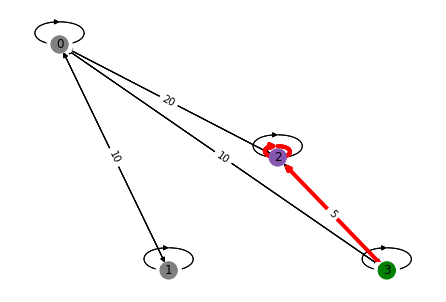

Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 1.00000e+00 9.99999e-33 9.99999e-33 9.99999e-33]


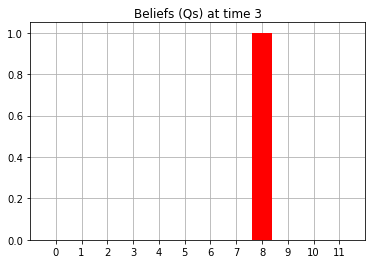


------------------------
Timestep  4
State: (2, 2)
CEFES [322.3654479980469, 397.3654479980469, 225.87994861602783, 475.87994861602783, 236.62269830703735, 225.87994861602783, 140.1371989250183, 397.3654479980469, 686.6226983070374, 386.62269830703735, 311.62269830703735, 150.87994861602783]
length 12
chosen-idx 6
u 27
Action: ((2, 2), (2, 2)) (index 27)
New state: (2, 2)
Observation: [(2, 2), 0]
Graph:


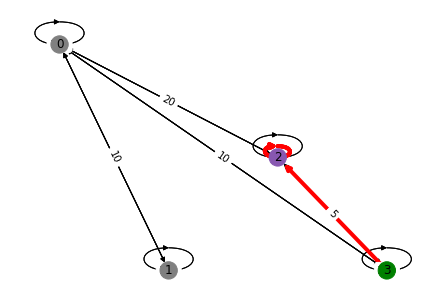

Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 1.00000e+00 9.99999e-33 9.99999e-33 9.99999e-33]


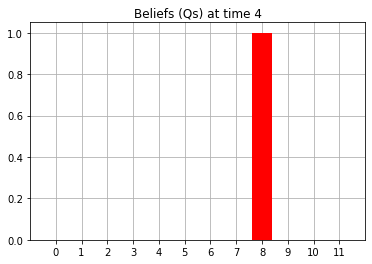


------------------------
Timestep  5
State: (2, 2)
CEFES [322.3654479980469, 397.3654479980469, 225.87994861602783, 475.87994861602783, 236.62269830703735, 225.87994861602783, 140.1371989250183, 397.3654479980469, 686.6226983070374, 386.62269830703735, 311.62269830703735, 150.87994861602783]
length 12
chosen-idx 6
u 27
Action: ((2, 2), (2, 2)) (index 27)
New state: (2, 2)
Observation: [(2, 2), 0]
Graph:


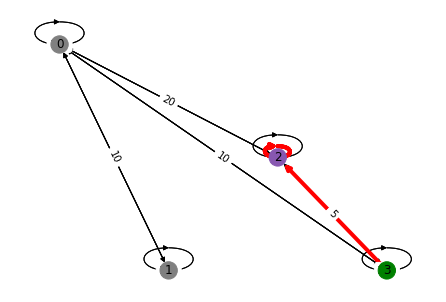

Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 1.00000e+00 9.99999e-33 9.99999e-33 9.99999e-33]


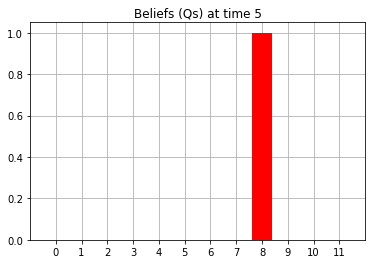


------------------------
Timestep  6
State: (2, 2)
CEFES [322.3654479980469, 397.3654479980469, 225.87994861602783, 475.87994861602783, 236.62269830703735, 225.87994861602783, 140.1371989250183, 397.3654479980469, 686.6226983070374, 386.62269830703735, 311.62269830703735, 150.87994861602783]
length 12
chosen-idx 6
u 27
Action: ((2, 2), (2, 2)) (index 27)
New state: (2, 2)
Observation: [(2, 2), 0]
Graph:


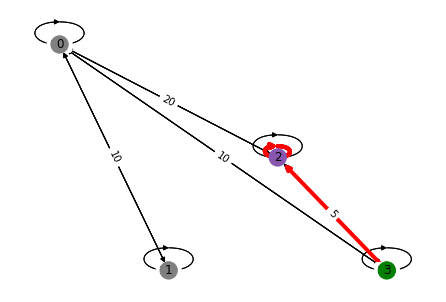

Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 1.00000e+00 9.99999e-33 9.99999e-33 9.99999e-33]


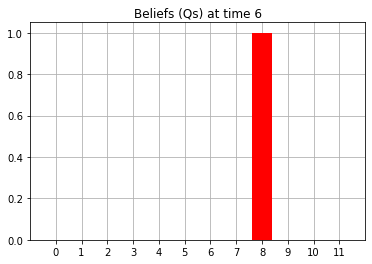


------------------------
Timestep  7
State: (2, 2)
CEFES [322.3654479980469, 397.3654479980469, 225.87994861602783, 475.87994861602783, 236.62269830703735, 225.87994861602783, 140.1371989250183, 397.3654479980469, 686.6226983070374, 386.62269830703735, 311.62269830703735, 150.87994861602783]
length 12
chosen-idx 6
u 27
Action: ((2, 2), (2, 2)) (index 27)
New state: (2, 2)
Observation: [(2, 2), 0]
Graph:


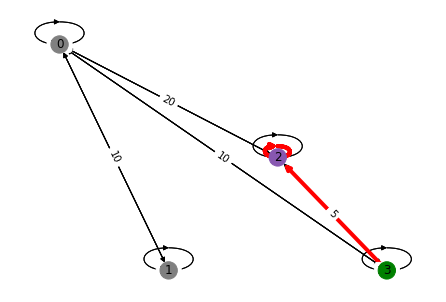

Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 1.00000e+00 9.99999e-33 9.99999e-33 9.99999e-33]


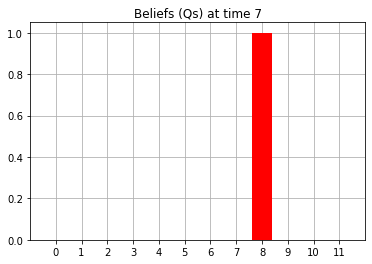


------------------------
Timestep  8
State: (2, 2)
CEFES [322.3654479980469, 397.3654479980469, 225.87994861602783, 475.87994861602783, 236.62269830703735, 225.87994861602783, 140.1371989250183, 397.3654479980469, 686.6226983070374, 386.62269830703735, 311.62269830703735, 150.87994861602783]
length 12
chosen-idx 6
u 27
Action: ((2, 2), (2, 2)) (index 27)
New state: (2, 2)
Observation: [(2, 2), 0]
Graph:


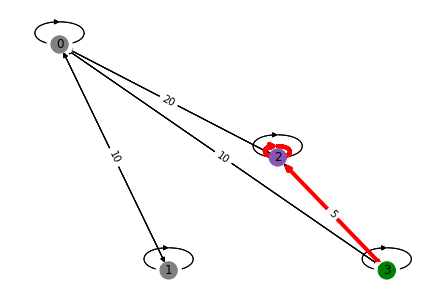

Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 1.00000e+00 9.99999e-33 9.99999e-33 9.99999e-33]


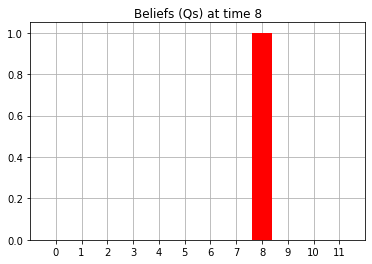


------------------------
Timestep  9
State: (2, 2)
CEFES [322.3654479980469, 397.3654479980469, 225.87994861602783, 475.87994861602783, 236.62269830703735, 225.87994861602783, 140.1371989250183, 397.3654479980469, 686.6226983070374, 386.62269830703735, 311.62269830703735, 150.87994861602783]
length 12
chosen-idx 6
u 27
Action: ((2, 2), (2, 2)) (index 27)
New state: (2, 2)
Observation: [(2, 2), 0]
Graph:


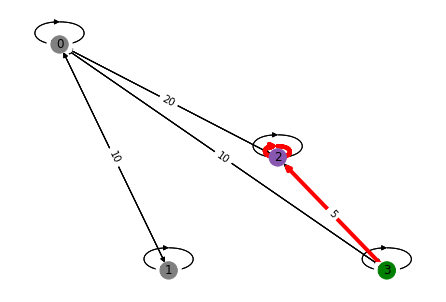

Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 1.00000e+00 9.99999e-33 9.99999e-33 9.99999e-33]


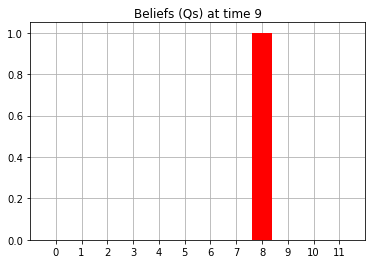

Times
[0.0067369937896728516, 0.007768154144287109, 0.00891876220703125, 0.009599924087524414, 0.008654117584228516, 0.008029937744140625, 0.009115934371948242, 0.008846044540405273, 0.008551836013793945, 0.008504867553710938]

Avg: 0.008472657203674317
km 0.3273041248321533
et {'EDM': 10.336161136627197, 'BOE': 0.042771339416503906, 'aBOE': 0.0476231575012207}


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 30.88it/s]



Initial state
-------------
Desired state 2
Initial beliefs [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Embedding:  BOE
Graph:


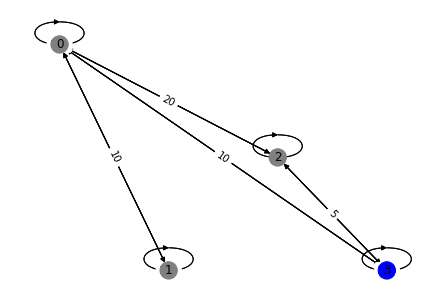


------------------------
Timestep  0
State: (2, 3)
CEFES [336.62269830703735, 650.8799486160278, 336.62269830703735, 797.3654479980469, 400.87994861602783, 115.13719892501831, 1247.3654479980469, 347.3654479980469, 1236.6226983070374, 786.6226983070374, 797.3654479980469, 425.87994861602783]
length 12
chosen-idx 5
u 23
Action: ((2, 3), (3, 2)) (index 23)
New state: (3, 2)
Observation: [(3, 2), 5]
Graph:


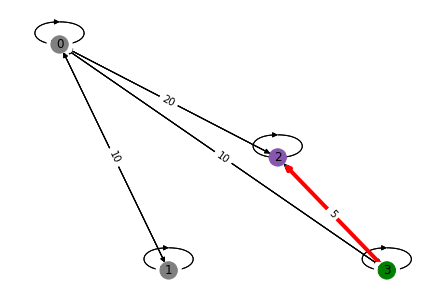

Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 1.00000e+00 9.99999e-33]


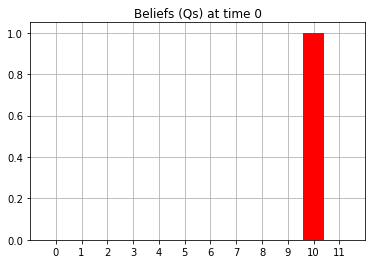


------------------------
Timestep  1
State: (3, 2)
CEFES [150.87994861602783, 386.62269830703735, 686.6226983070374, 397.3654479980469, 375.87994861602783, 322.3654479980469, 397.3654479980469, 836.6226983070374, 1222.3654479980469, 322.3654479980469, 311.62269830703735, 1297.3654479980469]
length 12
chosen-idx 0
u 34
Action: ((3, 2), (2, 2)) (index 34)
New state: (2, 2)
Observation: [(2, 2), 0]
Graph:


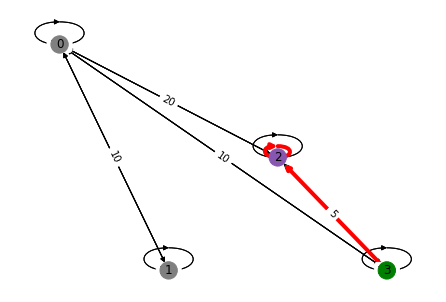

Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 1.00000e+00 9.99999e-33 9.99999e-33 9.99999e-33]


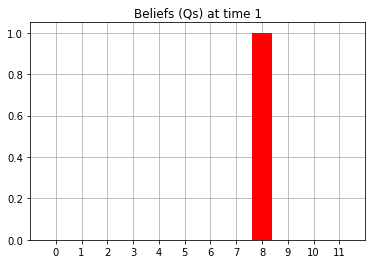


------------------------
Timestep  2
State: (2, 2)
CEFES [475.87994861602783, 175.87994861602783, 150.87994861602783, 386.62269830703735, 1222.3654479980469, 1747.3654479980469, 300.87994861602783, 397.3654479980469, 311.62269830703735, 397.3654479980469, 1297.3654479980469, 686.6226983070374]
length 12
chosen-idx 2
u 27
Action: ((2, 2), (2, 2)) (index 27)
New state: (2, 2)
Observation: [(2, 2), 0]
Graph:


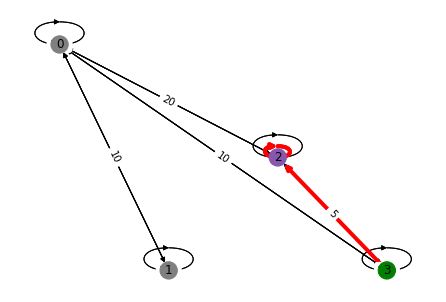

Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 1.00000e+00 9.99999e-33 9.99999e-33 9.99999e-33]


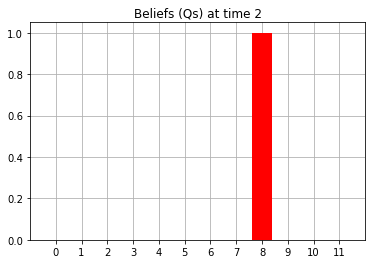


------------------------
Timestep  3
State: (2, 2)
CEFES [475.87994861602783, 175.87994861602783, 150.87994861602783, 386.62269830703735, 1222.3654479980469, 1747.3654479980469, 300.87994861602783, 397.3654479980469, 311.62269830703735, 397.3654479980469, 1297.3654479980469, 686.6226983070374]
length 12
chosen-idx 2
u 27
Action: ((2, 2), (2, 2)) (index 27)
New state: (2, 2)
Observation: [(2, 2), 0]
Graph:


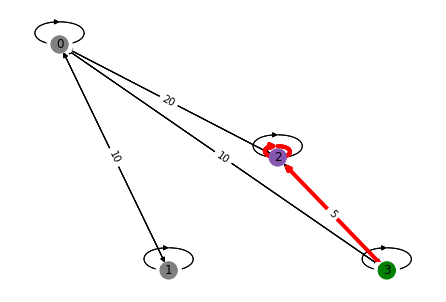

Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 1.00000e+00 9.99999e-33 9.99999e-33 9.99999e-33]


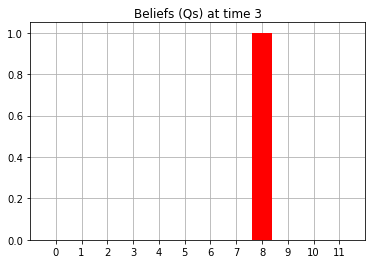


------------------------
Timestep  4
State: (2, 2)
CEFES [475.87994861602783, 175.87994861602783, 150.87994861602783, 386.62269830703735, 1222.3654479980469, 1747.3654479980469, 300.87994861602783, 397.3654479980469, 311.62269830703735, 397.3654479980469, 1297.3654479980469, 686.6226983070374]
length 12
chosen-idx 2
u 27
Action: ((2, 2), (2, 2)) (index 27)
New state: (2, 2)
Observation: [(2, 2), 0]
Graph:


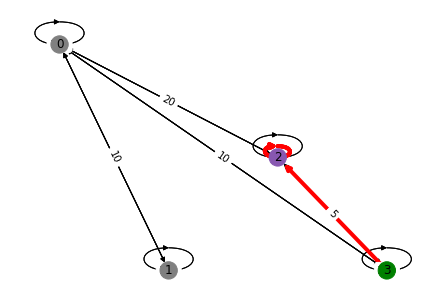

Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 1.00000e+00 9.99999e-33 9.99999e-33 9.99999e-33]


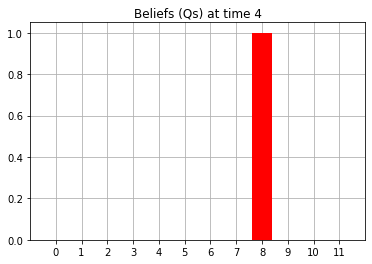


------------------------
Timestep  5
State: (2, 2)
CEFES [475.87994861602783, 175.87994861602783, 150.87994861602783, 386.62269830703735, 1222.3654479980469, 1747.3654479980469, 300.87994861602783, 397.3654479980469, 311.62269830703735, 397.3654479980469, 1297.3654479980469, 686.6226983070374]
length 12
chosen-idx 2
u 27
Action: ((2, 2), (2, 2)) (index 27)
New state: (2, 2)
Observation: [(2, 2), 0]
Graph:


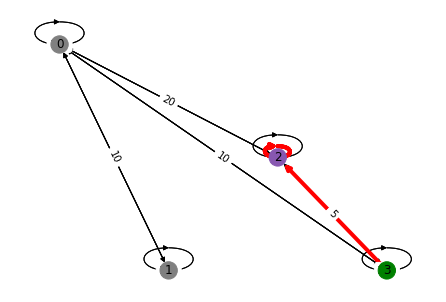

Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 1.00000e+00 9.99999e-33 9.99999e-33 9.99999e-33]


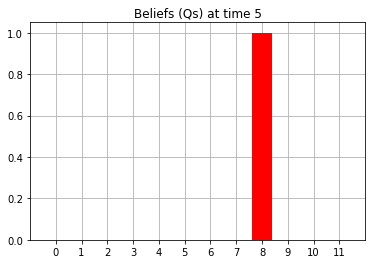


------------------------
Timestep  6
State: (2, 2)
CEFES [475.87994861602783, 175.87994861602783, 150.87994861602783, 386.62269830703735, 1222.3654479980469, 1747.3654479980469, 300.87994861602783, 397.3654479980469, 311.62269830703735, 397.3654479980469, 1297.3654479980469, 686.6226983070374]
length 12
chosen-idx 2
u 27
Action: ((2, 2), (2, 2)) (index 27)
New state: (2, 2)
Observation: [(2, 2), 0]
Graph:


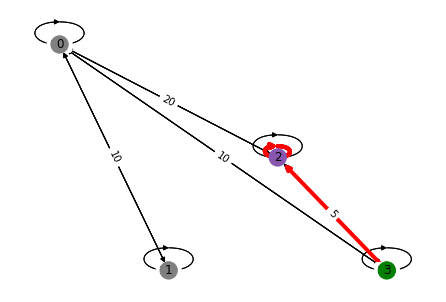

Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 1.00000e+00 9.99999e-33 9.99999e-33 9.99999e-33]


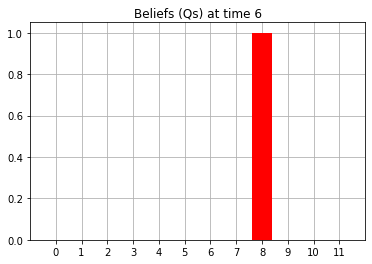


------------------------
Timestep  7
State: (2, 2)
CEFES [475.87994861602783, 175.87994861602783, 150.87994861602783, 386.62269830703735, 1222.3654479980469, 1747.3654479980469, 300.87994861602783, 397.3654479980469, 311.62269830703735, 397.3654479980469, 1297.3654479980469, 686.6226983070374]
length 12
chosen-idx 2
u 27
Action: ((2, 2), (2, 2)) (index 27)
New state: (2, 2)
Observation: [(2, 2), 0]
Graph:


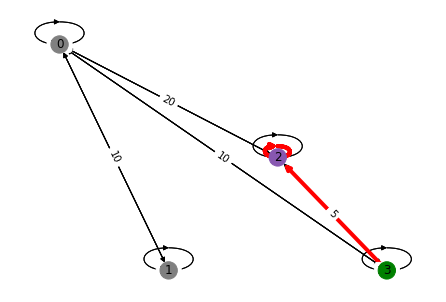

Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 1.00000e+00 9.99999e-33 9.99999e-33 9.99999e-33]


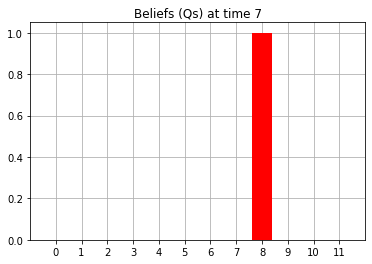


------------------------
Timestep  8
State: (2, 2)
CEFES [475.87994861602783, 175.87994861602783, 150.87994861602783, 386.62269830703735, 1222.3654479980469, 1747.3654479980469, 300.87994861602783, 397.3654479980469, 311.62269830703735, 397.3654479980469, 1297.3654479980469, 686.6226983070374]
length 12
chosen-idx 2
u 27
Action: ((2, 2), (2, 2)) (index 27)
New state: (2, 2)
Observation: [(2, 2), 0]
Graph:


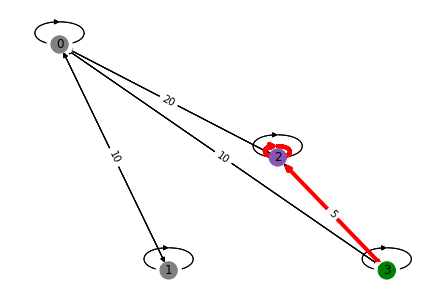

Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 1.00000e+00 9.99999e-33 9.99999e-33 9.99999e-33]


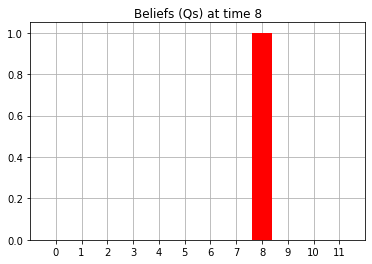


------------------------
Timestep  9
State: (2, 2)
CEFES [475.87994861602783, 175.87994861602783, 150.87994861602783, 386.62269830703735, 1222.3654479980469, 1747.3654479980469, 300.87994861602783, 397.3654479980469, 311.62269830703735, 397.3654479980469, 1297.3654479980469, 686.6226983070374]
length 12
chosen-idx 2
u 27
Action: ((2, 2), (2, 2)) (index 27)
New state: (2, 2)
Observation: [(2, 2), 0]
Graph:


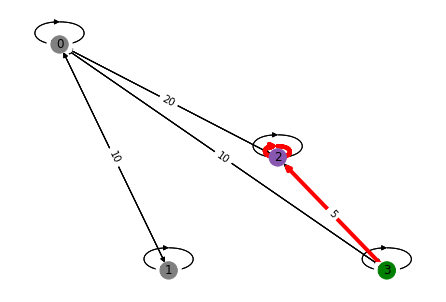

Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 1.00000e+00 9.99999e-33 9.99999e-33 9.99999e-33]


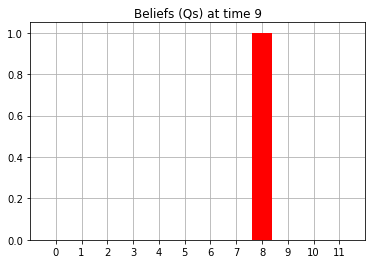

Times
[0.007238864898681641, 0.008325815200805664, 0.007349967956542969, 0.007428169250488281, 0.0076291561126708984, 0.007451057434082031, 0.008380889892578125, 0.007630109786987305, 0.007955074310302734, 0.0076122283935546875]

Avg: 0.007700133323669434


In [39]:
G = generate_graph(4)
agent = GraphAgent(G)
print("et", agent.construction_times)
agent.reset_state("aBOE")
print("km", agent.kmeans_time)
print("et", agent.construction_times)


sim = Simulation(agent)

sim.run()
print("km", agent.kmeans_time)
print("et", agent.construction_times)


sim.agent.reset_state("BOE")
sim.run()

In [441]:
def run_simulation(N=5, T=10, graph=None, states=None, observations=None, actions=None, num_states=None, num_state_factors=None, num_actions=None, num_modalities=None, num_observations=None, all_policies=None, embedding=None, A=None, B=None, C=None, D=None, weights=None, weight_coefficient=5, embedding_type="None", random_seed=None):
    assert embedding_type in ["None", "BOE", "EDM"], "Use `None` (full policy search), `BOE` (Bag-of-Edges) or `EDM` (Edit Distance Matrix) for `embedding_type` argument"
 
    if random_seed:
        np.random.seed(random_seed)
        
    if not graph:
        graph = generate_graph(N)
        plot_graph(graph)
        states, observations, actions, num_state_factors, num_states, num_modalities, num_observations, num_actions, weights = state_space_from_graph(graph)
    
    A = A or A_setup(num_states, num_state_factors)
    B = B or B_setup(states, G, num_states, num_state_factors, num_actions)

    if B is None:
        B = B_setup(states, G, num_states, num_state_factors, num_actions)

    if C is None:
        C = C_setup(states, num_states)

    if D is None:
        D = D_setup(graph, num_states, num_state_factors)
        
    if all_policies is None:
        policy_len = len(list(graph.nodes()))
        all_policies = get_policies_from_graph(graph, actions, num_state_factors, use_pool=False)
    
    if embedding_type == "EDM" and embedding is None:
        embedding = edit_distance_matrix(all_policies)
    elif embedding_type == "BOP" and embedding is None:
        embedding = bag_of_edges(all_policies)
    
    beliefs = D[0]
    state = np.argmax(beliefs) # initial state set to believed state
    state_history = [state]
    
    durations = []
    moves = []

    nx.set_node_attributes(graph, "grey", name="node_color")
    nx.set_node_attributes(graph, {states['node_pair'][state][1]: "blue"}, name="node_color")

    print("Initial beliefs", beliefs)
    print("C matrix", C)

    print("Graph:")
    plot_graph(graph)

    for t in range(T):
        A, B, C, weight_coefficient, duration, move, state, state_history, beliefs = simulation_step(
            t,
            graph,
            state, 
            beliefs, 
            A,
            B,
            C,
            all_policies,
            weights,
            weight_coefficient,
            state_history,
            embedding=embedding
        )
        durations.append(duration)
        moves.append(move)
    
    return durations, moves, graph


def infer_policies_kmeans(current_location, embedding_dict, all_policies, b, A, B, C, weights, weight_coefficient):
    
    # local_policies = get_local_policies(all_policies, current_location)
    local_embedding = embeddings_dict[current_location]["embedding"]
    local_kmeans = embeddings_dict[current_location]["kmeans"]
    local_embedding, local_kmeans = get_kmeans_local(embedding, current_location, all_policies)
    local_agent_clusters, local_agent_cluster_centers = get_agent_kmeans(local_policies, local_embedding, local_kmeans)    
    return select_policy_kmeans(local_agent_cluster_centers, local_agent_clusters, local_policies, b, A[0], B[0], C[0], weights, weight_coefficient)
                                    

# agent_data = {
#     "A": A,
#     "B": B,
#     "C": C,
#     "D": D,
#     "beliefs": b,
#     "weight_coefficient": weight_coefficient,
#     "all_policies": all_policies,
#     "current_location": None,
    
# }


def simulation_step(t, G, s, b, A, B, C, policies, weights, weight_coefficient, state_history, node_history, embedding=None):
    print("")
    print("------------------------")
    print("Timestep ", t)

    print(f"State: {states['node_pair'][s]}")
    current_location = states["node_pair"][s]
    
    start = time.time()
    if embedding is not None:
        policies = infer_policies_kmeans(
            current_location, 
            embedding,
            policies,
            b,
            A,
            B,
            C,
            weights, weight_coefficient
        )
    a, EFE = infer_action(policies, b, A[0], B[0], C[0], num_states, [num_actions], policy_len, weights, weight_coefficient)    
    duration = time.time() - start
    
    a = int(a)
    print(f"Action: {actions['change_location'][a]} (index {a})")
    
    # perform action in the environment and update the environment
    s = utils.sample(np.float32(B_gp)[0][:, s, a])
    print(f"New state: {states['node_pair'][s]}")
    o = utils.sample(np.float32(A_gp)[0][:,s])
    print(f"Observation: {observations['pair_plus_edge_weight'][o]}")

    # keep a running record of states
    state_history.append(s)
    loc = states["node_pair"][s][1]
    node_history.append(loc)

    
    print("Graph:")
    nx.set_node_attributes(G, "grey", name="node_color")
    nx.set_node_attributes(G, {states['node_pair'][s][1]: "blue"}, name="node_color")
    plot_graph(G, node_history)
                
    # Update agent's model parameters
    A, B, C, weight_coefficient = update_agent(
        G, 
        policy_len, 
        all_policies, 
        s, 
        state_history, 
        weight_coefficient, 
        desired_node, 
        recompute_policies=False,
        impatience=False
    )

    # infer new hidden state
    b = softmax(np.log(np.float32(A[0][o,:]) + 1e-16) + np.log(np.float32(B[0][:,:,a].dot(b)) + 1e-16))
    print(f"Beliefs: ", b)
    
    plot_beliefs(b, f"Beliefs (Qs) at time {t}")
    
    return A, B, C, weight_coefficient, duration, loc, s, state_history, node_history, b 

In [479]:
def random_simulation(embedding_type="BOEA", N=5):
    assert embedding_type in ["None", "BOE", "BOEA", "EDM"], "Use `None` (full policy search), `BOE` (Bag-of-Edges) or `EDM` (Edit Distance Matrix) for `embedding_type` argument"
 
        
    graph = generate_graph(N)
    plot_graph(graph)
    states, observations, actions, num_state_factors, num_states, num_modalities, num_observations, num_actions, weights = state_space_from_graph(graph)

    A = A_setup(num_states, num_state_factors)

    B = B_setup(states, graph, num_states, num_state_factors, num_actions)

    C = C_setup(states, num_states)

    D = D_setup(graph, num_states, num_state_factors)
        
    policy_len = len(list(graph.nodes()))
    all_policies = get_policies_from_graph(graph, actions, num_state_factors, use_pool=False)
    
    embedding = bag_of_edges_augmented(graph, all_policies)
    embeddings_dict = create_local_embeddings(graph, embedding, all_policies)
    
    beliefs = D[0]
    state = np.argmax(beliefs) # initial state set to believed state
    state_history = [state]
    loc = states["node_pair"][state][1]
    node_history = [loc]
    
    A_backup = copy.deepcopy(A)
    B_backup = copy.deepcopy(B)
    C_backup = copy.deepcopy(C)
    state_history_backup= copy.deepcopy(state_history)
    state_backup = copy.deepcopy(state)
    node_history_backup = copy.deepcopy(node_history)
    belief_backup = copy.deepcopy(beliefs)
    
    normal_durations = []
    normal_moves = []

    nx.set_node_attributes(graph, "grey", name="node_color")
    nx.set_node_attributes(graph, {states['node_pair'][state][1]: "blue"}, name="node_color")

    print("Initial beliefs", beliefs)
    print("C matrix", C)

    print("Graph:")
    plot_graph(graph)

    np.random.seed(random_seed)

    print("Normal sim...")
    for t in range(T):
        A, B, C, weight_coefficient, duration, move, state, state_history, node_history, beliefs = simulation_step(
            t,
            graph,
            state, 
            beliefs, 
            A,
            B,
            C,
            all_policies,
            weights,
            weight_coefficient,
            state_history,
            node_history,
            embedding=None
        )
        normal_durations.append(duration)
        normal_moves.append(move)

    A = A_backup 
    B = B_backup
    C = C_backup
    state_history = state_history_backup
    state = state_backup
    beliefs = belief_backup
    
    k_durations = []
    k_moves = []

    nx.set_node_attributes(graph, "grey", name="node_color")
    nx.set_node_attributes(graph, {states['node_pair'][state][1]: "blue"}, name="node_color")
    print("Embedding sim...")

    np.random.seed(random_seed)

    
    for t in range(T):
        A, B, C, weight_coefficient, duration, move, state, state_history, beliefs = simulation_step(
            t,
            graph,
            state, 
            beliefs, 
            A,
            B,
            C,
            all_policies,
            weights,
            weight_coefficient,
            state_history,
            embedding=embedding_dict
        )
        k_durations.append(duration)
        k_moves.append(move)    
        
    return normal_durations, normal_moves, k_durations, k_moves, graph

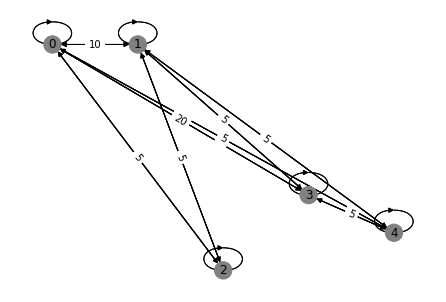

IndexError: list index out of range

In [480]:
nd, nm, kd, km, gra = random_simulation()

destination 2
Desired indices [ 5 10]
Initial beliefs [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
C matrix [[0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.
  0. ]]
Graph:


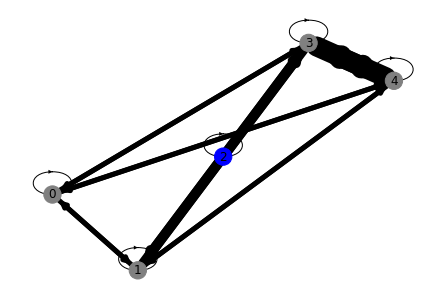


------------------------
Timestep  0
State: (2, 2)
Action: ((3, 3), (3, 0)) (index 56)
New state: (2, 2)
Observation: [(2, 2), 0]
Graph:


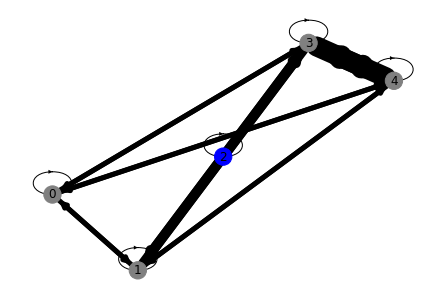

destination 4
Desired indices [ 2  7 13 18]
Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 1.00000e+00 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33]


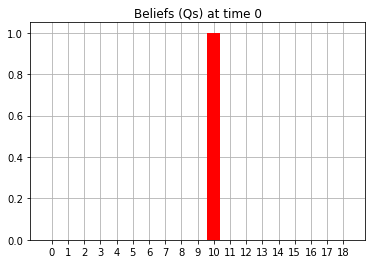


------------------------
Timestep  1
State: (2, 2)
Action: ((2, 2), (2, 1)) (index 41)
New state: (2, 1)
Observation: [(2, 1), 5]
Graph:


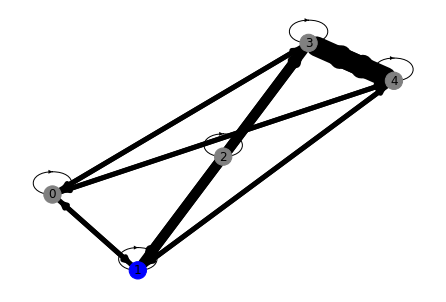

destination 4
Desired indices [ 2  7 13 18]
Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 1.00000e+00 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33]


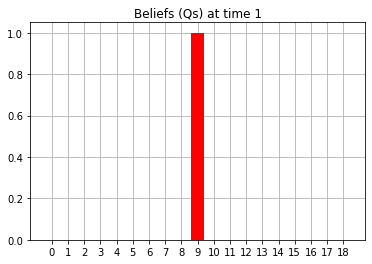


------------------------
Timestep  2
State: (2, 1)
Action: ((2, 1), (1, 4)) (index 39)
New state: (1, 4)
Observation: [(1, 4), 5]
Graph:


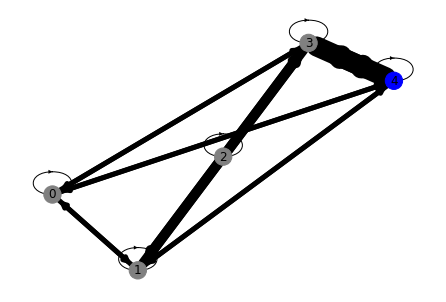

destination 4
Desired indices [ 2  7 13 18]
Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 1.00000e+00 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33]


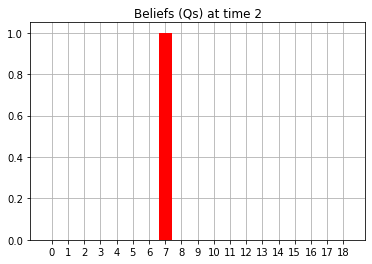


------------------------
Timestep  3
State: (1, 4)
Action: ((0, 4), (4, 1)) (index 10)
New state: (4, 4)
Observation: [(4, 4), 0]
Graph:


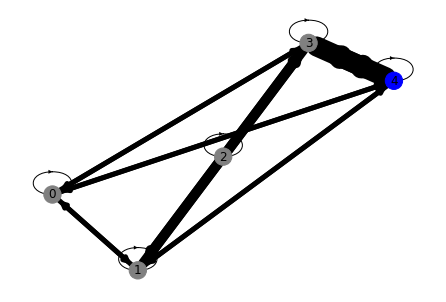

destination 4
Desired indices [ 2  7 13 18]
Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 1.00000e+00]


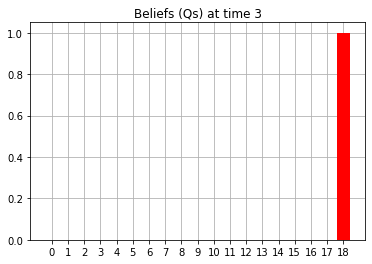


------------------------
Timestep  4
State: (4, 4)
Action: ((3, 1), (1, 1)) (index 51)
New state: (4, 4)
Observation: [(4, 4), 0]
Graph:


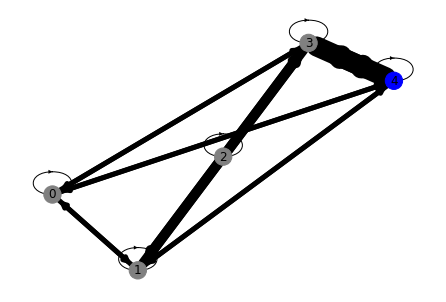

destination 4
Desired indices [ 2  7 13 18]
Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 1.00000e+00]


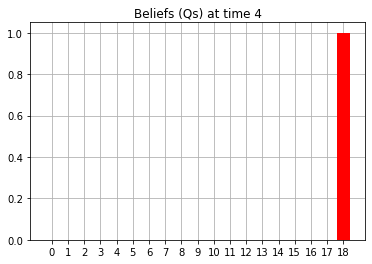


------------------------
Timestep  5
State: (4, 4)
Action: ((3, 3), (3, 4)) (index 58)
New state: (4, 4)
Observation: [(4, 4), 0]
Graph:


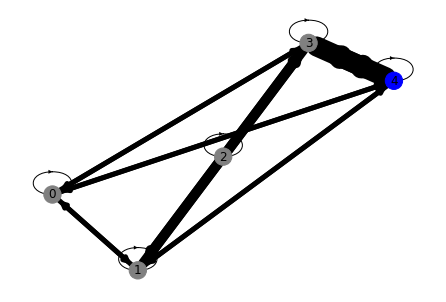

destination 4
Desired indices [ 2  7 13 18]
Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 1.00000e+00]


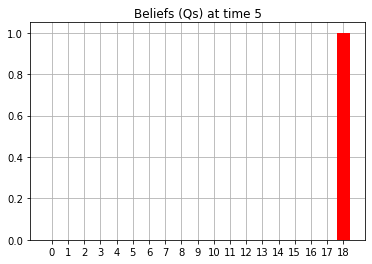


------------------------
Timestep  6
State: (4, 4)
Action: ((2, 1), (1, 4)) (index 39)
New state: (4, 4)
Observation: [(4, 4), 0]
Graph:


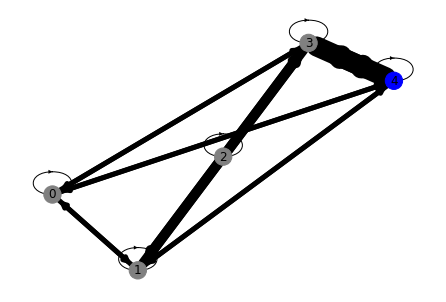

destination 4
Desired indices [ 2  7 13 18]
Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 1.00000e+00]


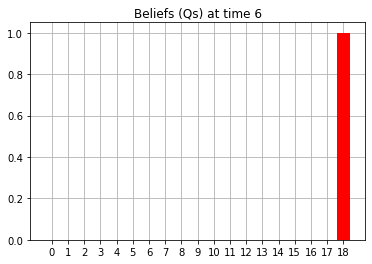


------------------------
Timestep  7
State: (4, 4)
Action: ((3, 3), (3, 1)) (index 57)
New state: (4, 4)
Observation: [(4, 4), 0]
Graph:


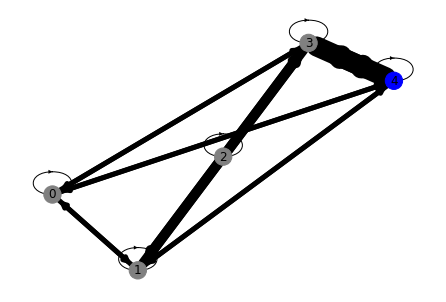

destination 4
Desired indices [ 2  7 13 18]
Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 1.00000e+00]


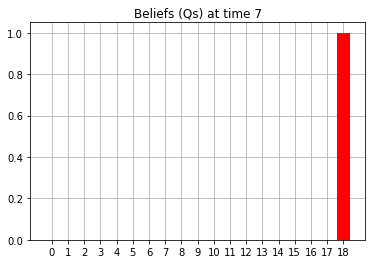


------------------------
Timestep  8
State: (4, 4)
Action: ((0, 0), (0, 1)) (index 13)
New state: (4, 4)
Observation: [(4, 4), 0]
Graph:


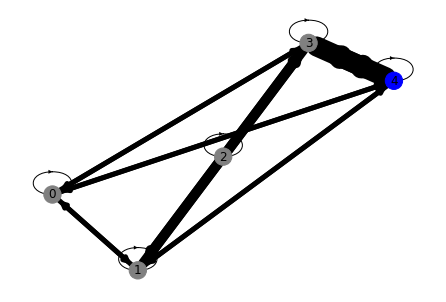

destination 4
Desired indices [ 2  7 13 18]
Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 1.00000e+00]


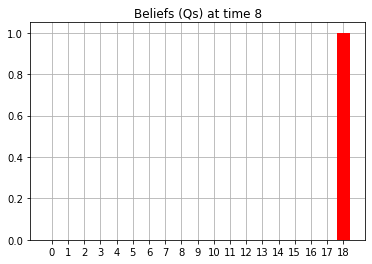


------------------------
Timestep  9
State: (4, 4)
Action: ((4, 1), (1, 0)) (index 64)
New state: (4, 4)
Observation: [(4, 4), 0]
Graph:


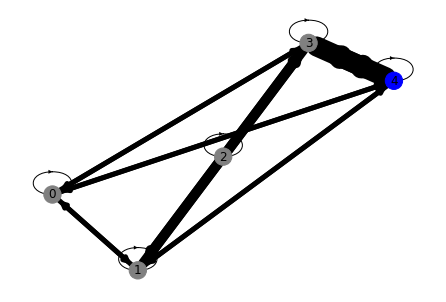

destination 4
Desired indices [ 2  7 13 18]
Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 1.00000e+00]


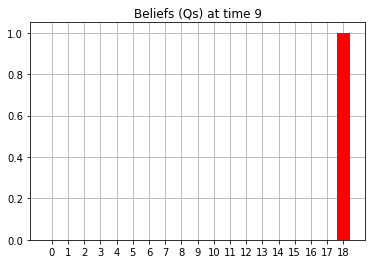

In [115]:
durations, moves, _ = run_simulation(
    N=5, 
    T=10, 
    graph=G, 
    states=states,
    observations=observations,
    all_policies=all_policies, 
    embedding=None, 
    A=A, 
    B=B, 
    # C=C, 
    # D=D,
    actions=actions,
    num_states=num_states,
    num_state_factors=num_state_factors,
    num_actions=num_actions,
    num_modalities=num_modalities,
    num_observations=num_observations,
    weights=weights,
    weight_coefficient=5, 
    embedding_type="None", 
    random_seed=None
)

In [103]:
print("Mean inference time: ", np.mean(durations))

Mean inference time:  8.027269196510314


Initial beliefs [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
C matrix [[0.   0.   0.25 0.   0.   0.   0.   0.25 0.   0.   0.   0.   0.   0.25
  0.   0.   0.   0.   0.25]]
Graph:


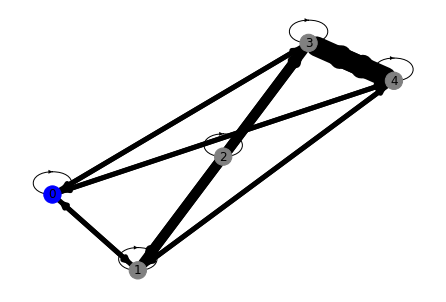


------------------------
Timestep  0
State: (0, 0)


21305it [00:00, 378022.68it/s]


chosen-idx 7
Action: ((0, 0), (0, 4)) (index 15)
New state: (0, 4)
Observation: [(0, 4), 5]
Graph:


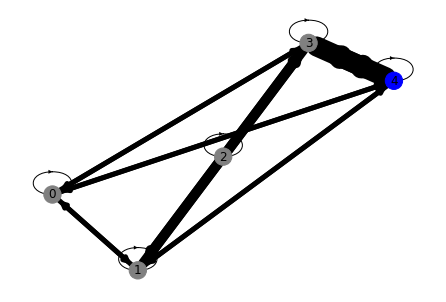

destination 4
Desired indices [ 2  7 13 18]
Beliefs:  [9.99999e-33 9.99999e-33 1.00000e+00 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33]


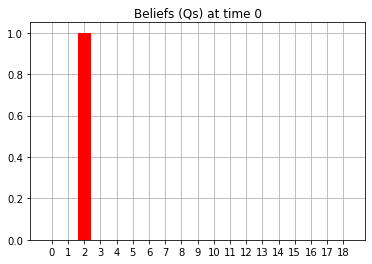


------------------------
Timestep  1
State: (0, 4)


21305it [00:00, 419314.28it/s]


chosen-idx 9
Action: ((0, 4), (4, 4)) (index 12)
New state: (4, 4)
Observation: [(4, 4), 0]
Graph:


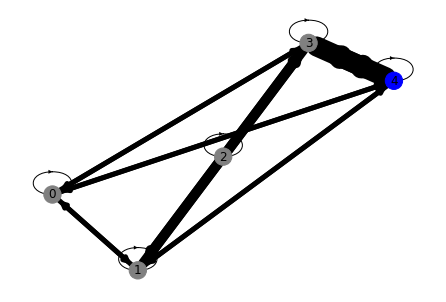

destination 4
Desired indices [ 2  7 13 18]
Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 1.00000e+00]


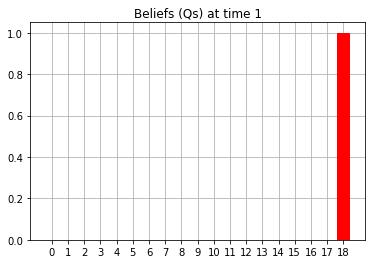


------------------------
Timestep  2
State: (4, 4)


21305it [00:00, 443881.93it/s]


chosen-idx 2
Action: ((4, 4), (4, 4)) (index 76)
New state: (4, 4)
Observation: [(4, 4), 0]
Graph:


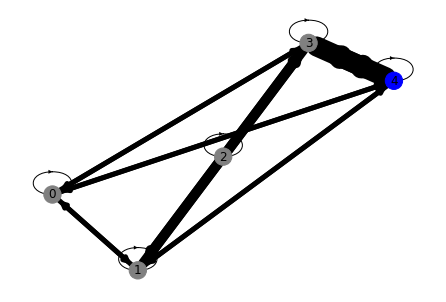

destination 4
Desired indices [ 2  7 13 18]
Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 1.00000e+00]


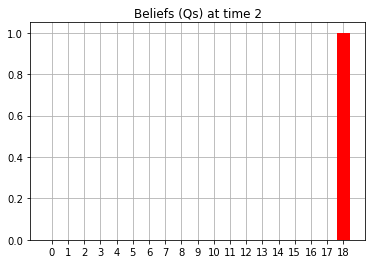


------------------------
Timestep  3
State: (4, 4)


21305it [00:00, 449120.18it/s]


chosen-idx 2
Action: ((4, 4), (4, 4)) (index 76)
New state: (4, 4)
Observation: [(4, 4), 0]
Graph:


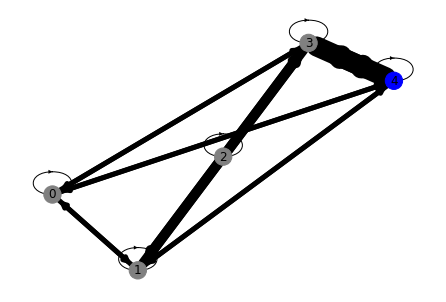

destination 4
Desired indices [ 2  7 13 18]
Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 1.00000e+00]


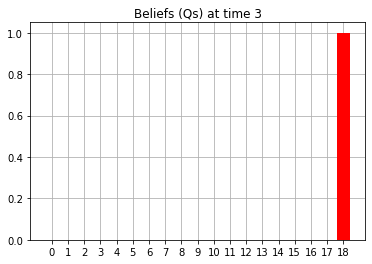


------------------------
Timestep  4
State: (4, 4)


21305it [00:00, 392177.69it/s]


chosen-idx 2
Action: ((4, 4), (4, 4)) (index 76)
New state: (4, 4)
Observation: [(4, 4), 0]
Graph:


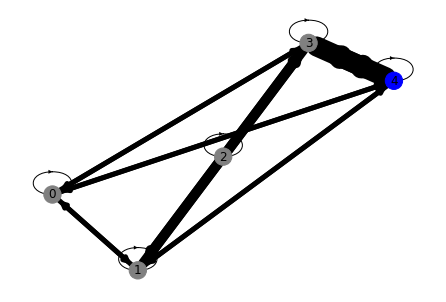

destination 4
Desired indices [ 2  7 13 18]
Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 1.00000e+00]


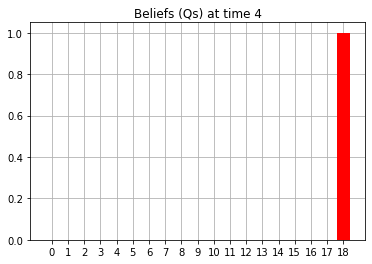


------------------------
Timestep  5
State: (4, 4)


21305it [00:00, 410234.07it/s]


chosen-idx 2
Action: ((4, 4), (4, 4)) (index 76)
New state: (4, 4)
Observation: [(4, 4), 0]
Graph:


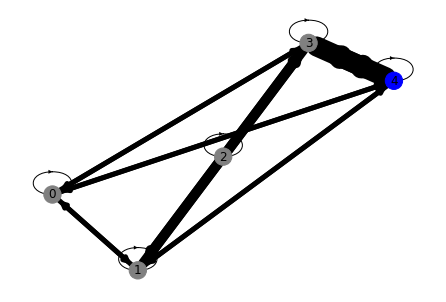

destination 4
Desired indices [ 2  7 13 18]
Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 1.00000e+00]


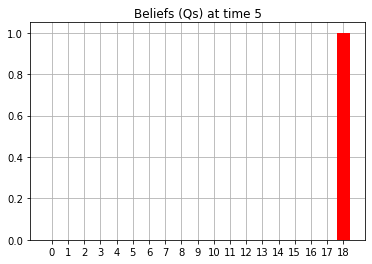


------------------------
Timestep  6
State: (4, 4)


21305it [00:00, 394633.59it/s]


chosen-idx 2
Action: ((4, 4), (4, 4)) (index 76)
New state: (4, 4)
Observation: [(4, 4), 0]
Graph:


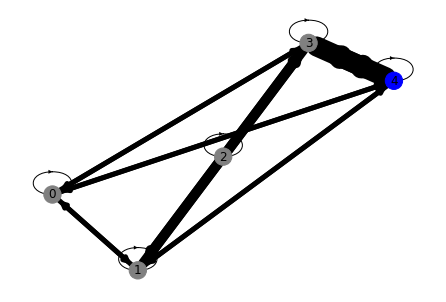

destination 4
Desired indices [ 2  7 13 18]
Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 1.00000e+00]


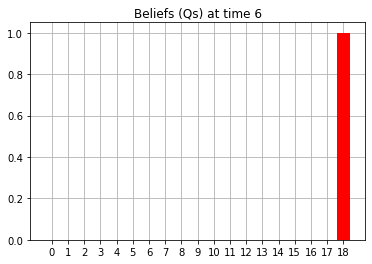


------------------------
Timestep  7
State: (4, 4)


21305it [00:00, 404532.66it/s]


chosen-idx 2
Action: ((4, 4), (4, 4)) (index 76)
New state: (4, 4)
Observation: [(4, 4), 0]
Graph:


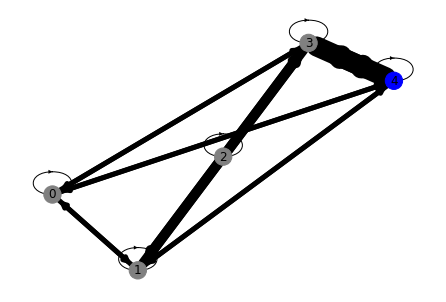

destination 4
Desired indices [ 2  7 13 18]
Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 1.00000e+00]


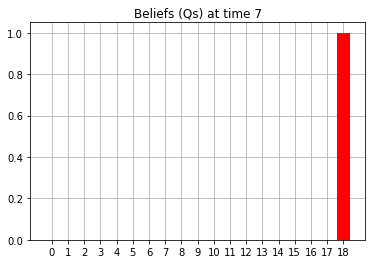


------------------------
Timestep  8
State: (4, 4)


21305it [00:00, 453190.49it/s]


chosen-idx 2
Action: ((4, 4), (4, 4)) (index 76)
New state: (4, 4)
Observation: [(4, 4), 0]
Graph:


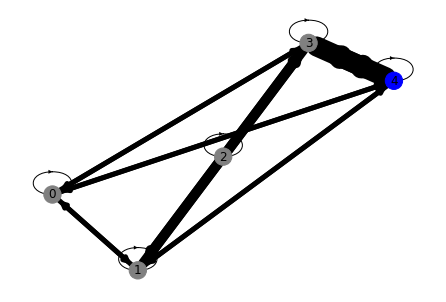

destination 4
Desired indices [ 2  7 13 18]
Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 1.00000e+00]


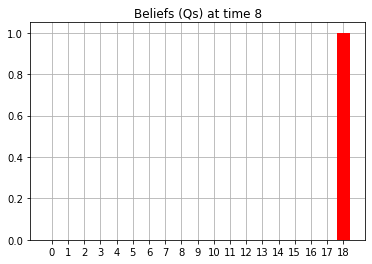


------------------------
Timestep  9
State: (4, 4)


21305it [00:00, 410826.28it/s]


chosen-idx 2
Action: ((4, 4), (4, 4)) (index 76)
New state: (4, 4)
Observation: [(4, 4), 0]
Graph:


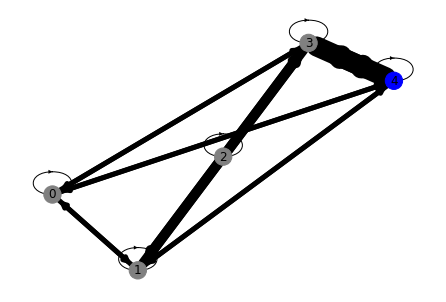

destination 4
Desired indices [ 2  7 13 18]
Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 1.00000e+00]


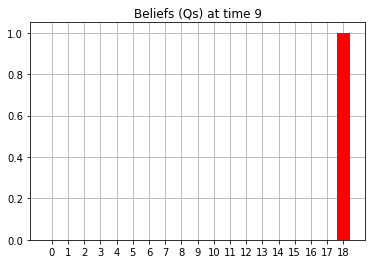

In [106]:
durations, moves, _ = run_simulation(
    N=5, 
    T=10, 
    graph=G, 
    states=states,
    observations=observations,
    all_policies=all_policies, 
    embedding=matrix, 
    A=A, 
    B=B, 
    C=C, 
    D=D,
    weights=weights,
    weight_coefficient=5, 
    embedding_type="EDM", 
    random_seed=None
)

In [107]:
print("Mean inference time: ", np.mean(durations))

Mean inference time:  9.012032556533814


[ 16 134 141  13 141 480 153 134 134 412 557  16 412 134 258 258 134 412
  98  16]
center_efes [353.29667472839355, 227.84160709381104, 598.7517423629761, 287.84160709381104, 598.7517423629761, 724.2068099975586, 598.7517423629761, 227.84160709381104, 227.84160709381104, 323.29667472839355, 484.2068099975586, 353.29667472839355, 323.29667472839355, 227.84160709381104, 364.2068099975586, 364.2068099975586, 227.84160709381104, 323.29667472839355, 418.7517423629761, 353.29667472839355]
mean_cluster_efes [307.15600323190495, 241.47822545214396, 400.14872314051576, 246.30623459171605, 400.14872314051576, 521.9522018814087, 383.5476144812573, 241.47822545214396, 241.47822545214396, 298.3716319844693, 420.3271611576349, 307.15600323190495, 298.3716319844693, 241.47822545214396, 310.29064574608435, 310.29064574608435, 241.47822545214396, 298.3716319844693, 348.09362089006527, 307.15600323190495]


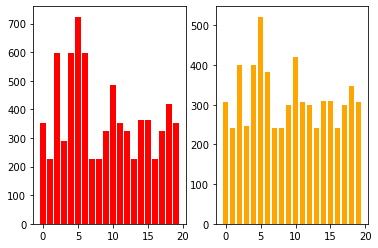

In [655]:
num_samples = 20

cluster_cents = np.random.choice(local_agent_cluster_centers, size=num_samples)
cc = [19]
print(cluster_cents)
center_efes = []
mean_cluster_efes = []
for idx, cluster_cent in enumerate(cluster_cents):
    center_efes.append(-evaluate_policy(local_policies[cluster_cent], initial_beliefs[0], A[0], B[0], C[0], weights, weight_coefficient))
    # print("center efes", center_efes)
    cluster = local_agent_clusters[list(local_agent_cluster_centers).index(cluster_cent)]
    cluster_efes = []
    for c in cluster:
        cluster_efes.append(-evaluate_policy(c, initial_beliefs[0], A[0], B[0], C[0], weights, weight_coefficient)   )
    mean_cluster_efes.append(np.mean(cluster_efes))

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.bar(range(num_samples), center_efes, color='red')
ax2.bar(range(num_samples), mean_cluster_efes, color='orange')

print("center_efes", center_efes)
print("mean_cluster_efes", mean_cluster_efes)

0
center_efes 184.2068099975586
mean_cluster_efes 184.9024157707508


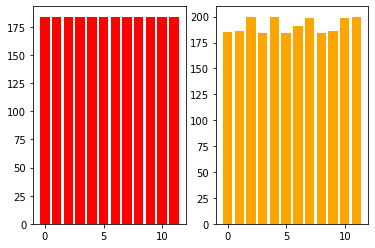

In [735]:
num_clusters = len(local_agent_cluster_centers)

#cluster_cents = np.random.choice(local_agent_cluster_centers, size=num_samples)
#print(cluster_cents)
center_efes = []
mean_cluster_efes = []
for idx, cluster_cent in enumerate(local_agent_cluster_centers):
    center_efes.append(-evaluate_policy(local_policies[cluster_cent], initial_beliefs[0], A[0], B[0], C[0], weights, weight_coefficient))
    cluster = local_agent_clusters[list(local_agent_cluster_centers).index(cluster_cent)]
    cluster_efes = []
    for c in cluster:
        cluster_efes.append(-evaluate_policy(c, initial_beliefs[0], A[0], B[0], C[0], weights, weight_coefficient)   )
    mean_cluster_efes.append(np.mean(cluster_efes))

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.bar(range(num_clusters), center_efes, color='red')
ax2.bar(range(num_clusters), mean_cluster_efes, color='orange')

i = np.argmin(center_efes)
print(i)
print("center_efes", center_efes[i])
print("mean_cluster_efes", mean_cluster_efes[i])


## 2D PCA / K-means visualization

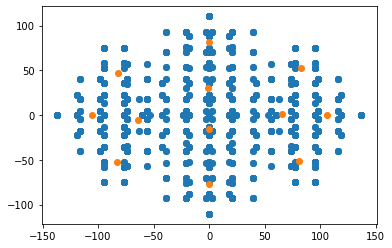

In [48]:
pca = PCA(n_components=2)
pca.fit(emb)

reduced_matrix = pca.transform(matrix)
plt.scatter(reduced_matrix[:,0], reduced_matrix[:,1])
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1])
plt.show()

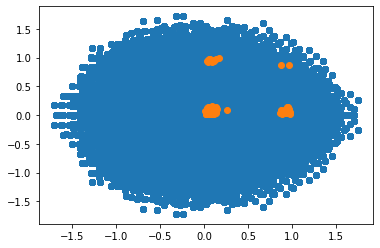

In [103]:
kmeans_bop2 = KMeans(n_clusters=100, random_state=0).fit(np.array(bop))
kmeans_bop2.cluster_centers_

kmeans_bop2.cluster_centers_[0]
pca = PCA(n_components=2)
pca.fit(bop)

reduced_matrix = pca.transform(bop)
plt.scatter(reduced_matrix[:,0], reduced_matrix[:,1])
plt.scatter(kmeans_bop2.cluster_centers_[:,0], kmeans_bop2.cluster_centers_[:,1])
plt.show()

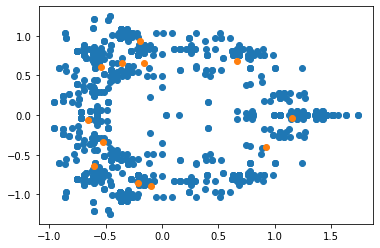

In [736]:
emb = embeddings_dict[(0,0)]["embedding"]
km = embeddings_dict[(0,0)]["kmeans"]

pca = PCA(n_components=2)
pca.fit(emb)

reduced_matrix = pca.transform(emb)
reduced_clusbop = pca.transform(km.cluster_centers_)

plt.scatter(reduced_matrix[:,0], reduced_matrix[:,1])
plt.scatter(reduced_clusbop[:,0], reduced_clusbop[:,1])
#plt.scatter(kmeans_bop.cluster_centers_[65,0], kmeans_bop.cluster_centers_[65,1])


plt.show()

In [685]:
embeddings_dict

{(0,
  2): {'embedding': [array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 8]),
   array([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 8]),
   array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 8]),
   array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 8]),
   array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 8]),
   array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 8]),
   array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 8]),
   array([1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 8]),
   array([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 8]),
   array([1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 8]),
   array([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 8]),
   array([1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 8]),
   array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 8]),
  

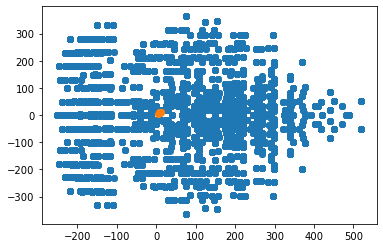

In [180]:
# pca = PCA(n_components=3)
# pca.fit(bop)
# reduced_matrix = pca.transform(bop)

# plt.scatter(reduced_matrix[:,0], reduced_matrix[:,1])
# plt.scatter(kmeans_bop.cluster_centers_[:,0], kmeans_bop.cluster_centers_[:,1])
# #plt.scatter(kmeans_bop.cluster_centers_[65,0], kmeans_bop.cluster_centers_[65,1])


# plt.show()

pca = PCA(n_components=3)
pca.fit(matrix)
reduced_matrix = pca.transform(matrix)

plt.scatter(reduced_matrix[:,0], reduced_matrix[:,1])
plt.scatter(kmeans_unreduced.cluster_centers_[:,0], kmeans_unreduced.cluster_centers_[:,1])
#plt.scatter(kmeans_bop.cluster_centers_[65,0], kmeans_bop.cluster_centers_[65,1])


plt.show()

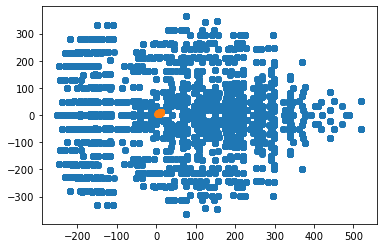

In [192]:
pca = PCA(n_components=3)
pca.fit(matrix)
reduced_matrix = pca.transform(matrix)

plt.scatter(reduced_matrix[:,0], reduced_matrix[:,1])
plt.scatter(kmeans_matrix.cluster_centers_[:,0], kmeans_matrix.cluster_centers_[:,1])
#plt.scatter(kmeans_bop.cluster_centers_[65,0], kmeans_bop.cluster_centers_[65,1])


plt.show()

In [5]:
pca = PCA(n_components=2)
pca.fit(local_embedding)
reduced_matrix = pca.transform(local_embedding)

plt.scatter(reduced_matrix[:,0], reduced_matrix[:,1])
plt.scatter(local_kmeans.cluster_centers_[:,0], local_kmeans.cluster_centers_[:,1])
#plt.scatter(kmeans_bop.cluster_centers_[65,0], kmeans_bop.cluster_centers_[65,1])


plt.show()

    # #print_policies(local_policies)
    # local_embedding, local_kmeans = get_kmeans_local(matrix, current_location, all_policies)
    # local_agent_clusters, local_agent_cluster_centers = get_agent_kmeans(local_policies, local_embedding, local_kmeans)    
    # local_cluster_policies = select_policy_kmeans(local_agent_cluster_centers, local_agent_clusters, local_policies, b, A[0], B[0], C[0], weights, weight_coefficient)



NameError: name 'local_embedding' is not defined

In [175]:
for idx, policy in enumerate(agent_cluster_centers):
    print(f"Center {idx}", expand(all_policies[policy]))

Center 0 [((1, 4), (4, 3)), ((4, 3), (3, 0)), ((3, 0), (0, 3)), ((0, 3), (3, 3)), ((3, 3), (3, 4))]
Center 1 [((0, 2), (2, 0)), ((2, 0), (0, 2)), ((0, 2), (2, 2)), ((2, 2), (2, 0)), ((2, 0), (0, 1))]
Center 2 [((1, 0), (0, 3)), ((0, 3), (3, 4)), ((3, 4), (4, 1)), ((4, 1), (1, 3)), ((1, 3), (3, 4))]
Center 3 [((0, 1), (1, 4)), ((1, 4), (4, 1)), ((4, 1), (1, 4)), ((1, 4), (4, 2)), ((4, 2), (2, 4))]
Center 4 [((1, 3), (3, 1)), ((3, 1), (1, 4)), ((1, 4), (4, 1)), ((4, 1), (1, 4)), ((1, 4), (4, 3))]
Center 5 [((1, 0), (0, 1)), ((0, 1), (1, 3)), ((1, 3), (3, 1)), ((3, 1), (1, 3)), ((1, 3), (3, 0))]
Center 6 [((2, 4), (4, 2)), ((4, 2), (2, 4)), ((2, 4), (4, 3)), ((4, 3), (3, 0)), ((3, 0), (0, 3))]
Center 7 [((1, 3), (3, 4)), ((3, 4), (4, 2)), ((4, 2), (2, 0)), ((2, 0), (0, 2)), ((0, 2), (2, 0))]
Center 8 [((0, 1), (1, 0)), ((1, 0), (0, 1)), ((0, 1), (1, 1)), ((1, 1), (1, 4)), ((1, 4), (4, 3))]
Center 9 [((1, 3), (3, 4)), ((3, 4), (4, 2)), ((4, 2), (2, 4)), ((2, 4), (4, 4)), ((4, 4), (4, 3))]


In [191]:
for idx, policy in enumerate(agent_cluster_centers):
    print(f"Center {idx}", expand(all_policies[policy]))

Center 0 [((1, 4), (4, 1)), ((4, 1), (1, 1)), ((1, 1), (1, 4)), ((1, 4), (4, 2)), ((4, 2), (2, 4))]
Center 1 [((1, 4), (4, 1)), ((4, 1), (1, 4)), ((1, 4), (4, 4)), ((4, 4), (4, 1)), ((4, 1), (1, 1))]
Center 2 [((0, 3), (3, 1)), ((3, 1), (1, 4)), ((1, 4), (4, 3)), ((4, 3), (3, 0)), ((3, 0), (0, 3))]
Center 3 [((4, 2), (2, 0)), ((2, 0), (0, 3)), ((0, 3), (3, 4)), ((3, 4), (4, 4)), ((4, 4), (4, 3))]
Center 4 [((3, 4), (4, 3)), ((4, 3), (3, 0)), ((3, 0), (0, 1)), ((0, 1), (1, 0)), ((1, 0), (0, 1))]
Center 5 [((1, 4), (4, 3)), ((4, 3), (3, 4)), ((3, 4), (4, 4)), ((4, 4), (4, 3)), ((4, 3), (3, 1))]
Center 6 [((0, 2), (2, 4)), ((2, 4), (4, 3)), ((4, 3), (3, 1)), ((3, 1), (1, 3)), ((1, 3), (3, 0))]
Center 7 [((3, 4), (4, 3)), ((4, 3), (3, 4)), ((3, 4), (4, 3)), ((4, 3), (3, 4)), ((3, 4), (4, 4))]
Center 8 [((1, 4), (4, 1)), ((4, 1), (1, 4)), ((1, 4), (4, 2)), ((4, 2), (2, 4)), ((2, 4), (4, 4))]
Center 9 [((0, 2), (2, 4)), ((2, 4), (4, 3)), ((4, 3), (3, 4)), ((3, 4), (4, 1)), ((4, 1), (1, 0))]
